In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

Train shape: (8990, 98)
Test shape: (10, 99)
Sample train columns: ['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1']
Target chosen: market_forward_excess_returns


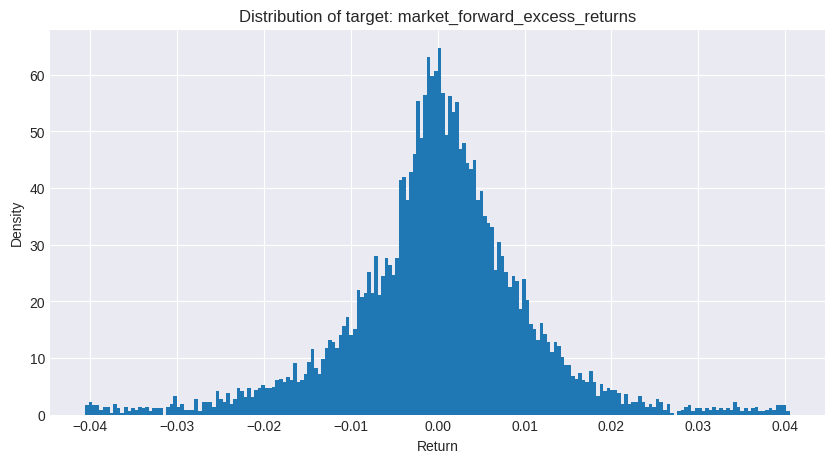

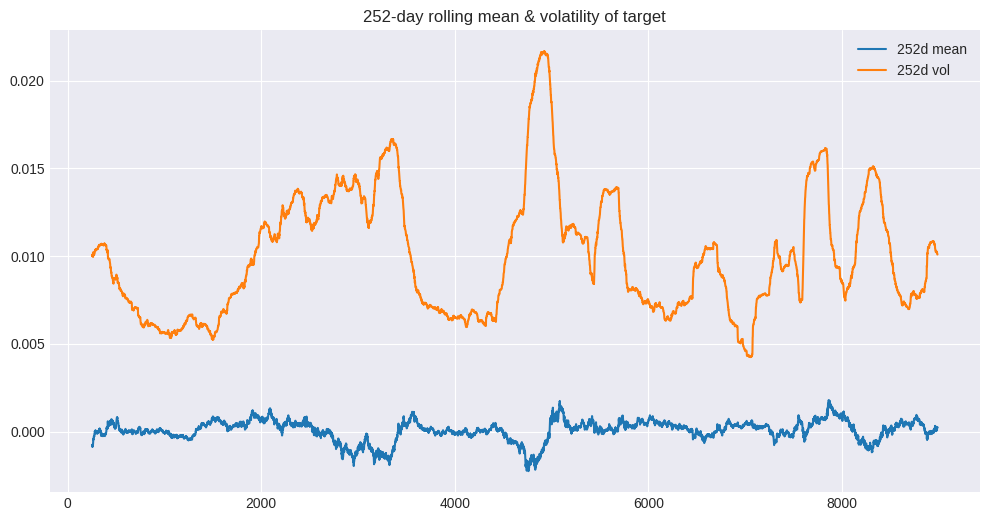

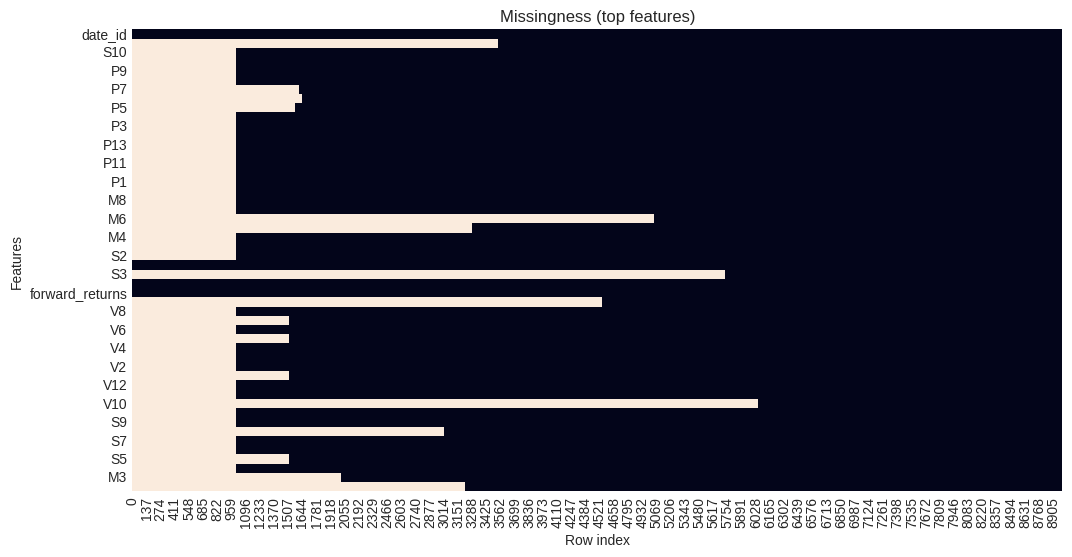

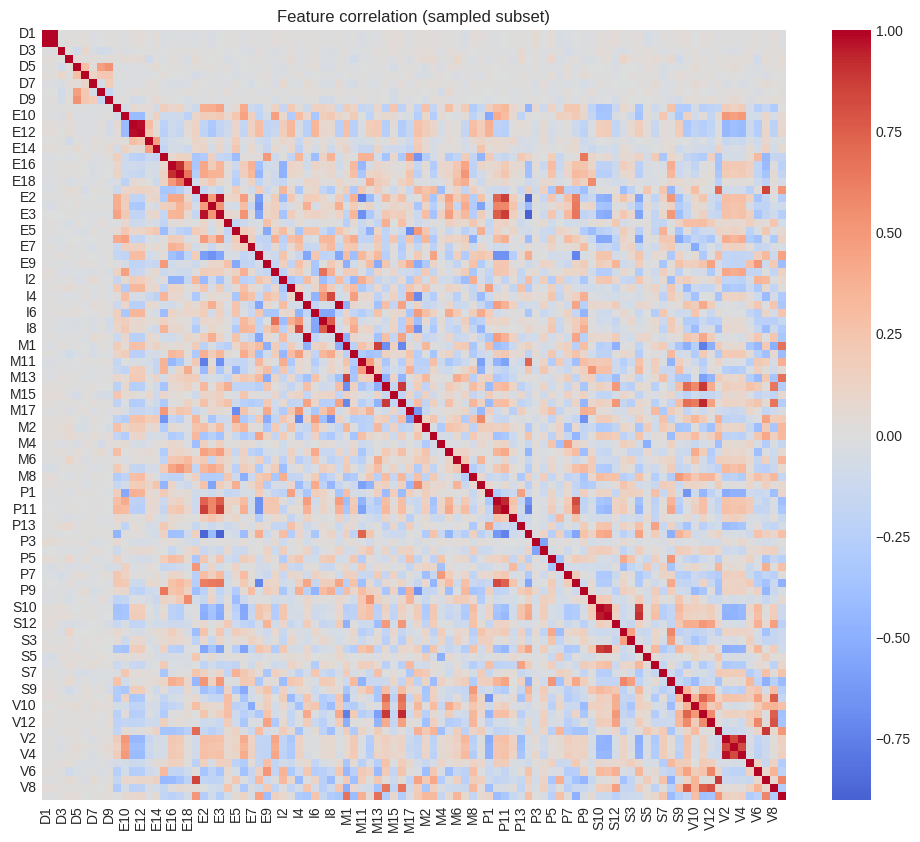


Explained variance ratio (first 6 PCs): [0.13108767 0.10745505 0.0847642  0.06110868 0.04329648 0.04013774]


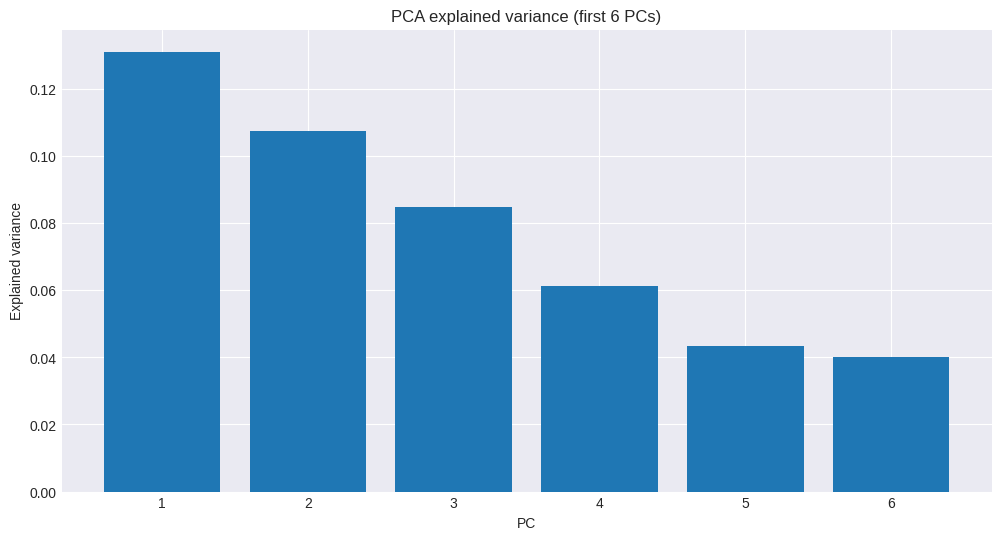


 EDA complete — dataset profiled, missingness visualized, correlations explored, PCA variance checked, and target dynamics plotted.


In [2]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn scipy statsmodels tqdm

# -------------------------
# 0) Imports & config
# -------------------------
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# plotting defaults
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (12,6)

# -------------------------
# 1) Load data
# -------------------------
DATA_DIR = "/kaggle/input/hull-tactical-market-prediction"
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH = os.path.join(DATA_DIR, "test.csv")

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('Sample train columns:', train.columns[:40].tolist())

# -------------------------
# 2) Preprocessing (EDA-friendly)
# -------------------------
TARGET = 'market_forward_excess_returns' if 'market_forward_excess_returns' in train.columns else 'forward_returns'
print('Target chosen:', TARGET)

train_sorted = train.sort_values('date_id').reset_index(drop=True)

# Fill strategy: forward-fill then backward-fill, then median
feature_cols = [c for c in train.columns if c not in ['date_id','forward_returns','risk_free_rate','market_forward_excess_returns']]
train_ffill = train_sorted.copy()
train_ffill[feature_cols] = train_ffill[feature_cols].ffill().bfill()
train_ffill.fillna(train_ffill.median(numeric_only=True), inplace=True)

# Winsorize extreme values
num_cols = train_ffill[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    low = train_ffill[c].quantile(0.005)
    high = train_ffill[c].quantile(0.995)
    train_ffill[c] = train_ffill[c].clip(lower=low, upper=high)

# -------------------------
# 3) Exploratory Data Analysis
# -------------------------

# 3.1 Target distribution
plt.figure(figsize=(10,5))
plt.hist(train_ffill[TARGET].dropna(), bins=200, density=True)
plt.title(f'Distribution of target: {TARGET}')
plt.xlabel('Return'); plt.ylabel('Density')
plt.show()

# 3.2 Rolling mean and volatility of target
plt.figure(figsize=(12,6))
ax = train_ffill[TARGET].rolling(252).mean().plot(label='252d mean')
train_ffill[TARGET].rolling(252).std().plot(label='252d vol', ax=ax)
ax.set_title('252-day rolling mean & volatility of target')
ax.legend(); plt.show()

# 3.3 Missingness heatmap for top features
present_pct = train_ffill.notna().mean()
top_feats = present_pct.sort_values(ascending=False).index[:50].tolist()
sns.heatmap(train_sorted[top_feats].isnull().T, cbar=False)
plt.title('Missingness (top features)')
plt.xlabel('Row index'); plt.ylabel('Features')
plt.show()

# 3.4 Correlation heatmap (sampled subset to reduce load)
corr_feats = train_ffill[num_cols].sample(frac=0.15, random_state=0)
corr = corr_feats.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature correlation (sampled subset)')
plt.show()

# 3.5 PCA overview
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_ffill[num_cols].fillna(0))
pc = PCA(n_components=6)
pc_comp = pc.fit_transform(X_scaled)

print('\nExplained variance ratio (first 6 PCs):', pc.explained_variance_ratio_)
plt.bar(range(1,7), pc.explained_variance_ratio_)
plt.xlabel('PC'); plt.ylabel('Explained variance')
plt.title('PCA explained variance (first 6 PCs)')
plt.show()

# 3.6 Interactive Plotly example: cumulative returns
train_ffill['cum_return'] = (1 + train_ffill[TARGET].fillna(0)).cumprod()
fig = px.line(train_ffill, x='date_id', y='cum_return', title='Cumulative returns over time')
fig.show()

print("\n EDA complete — dataset profiled, missingness visualized, correlations explored, PCA variance checked, and target dynamics plotted.")


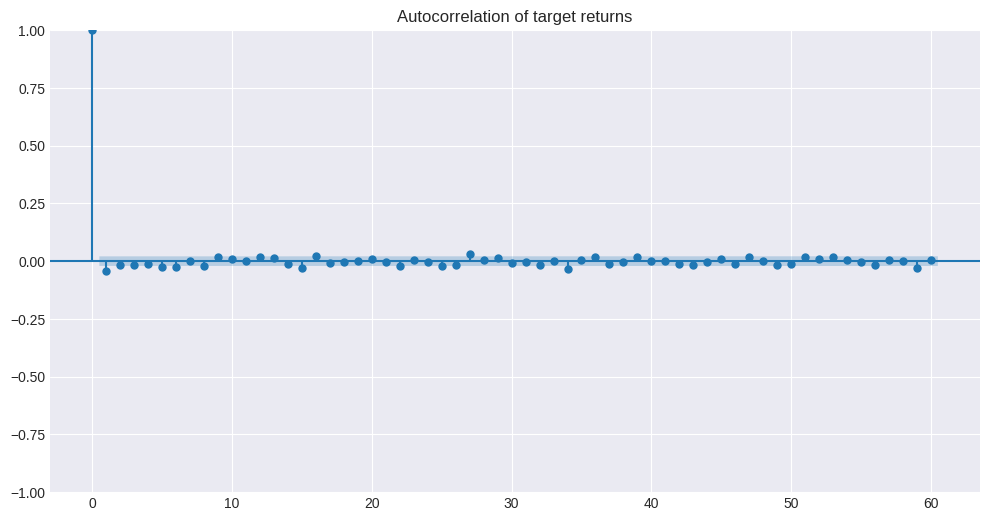

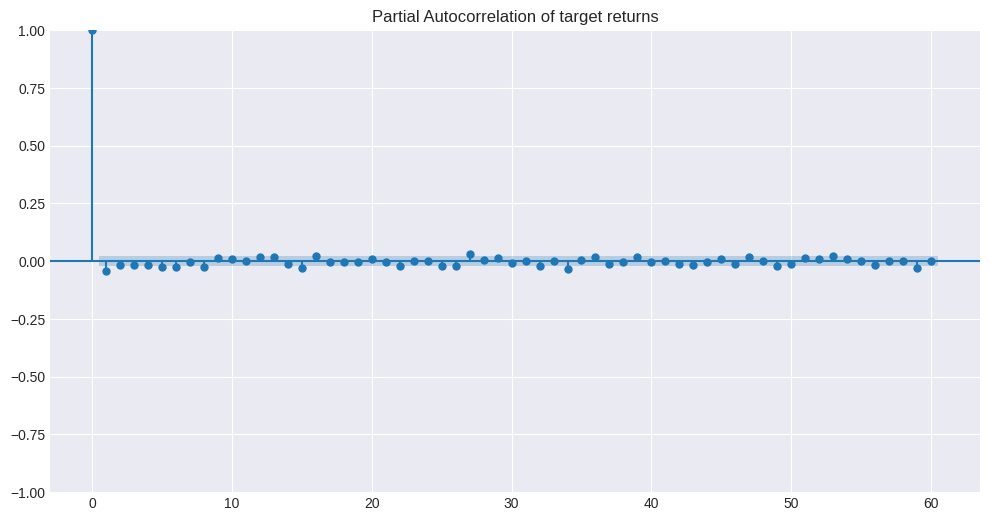

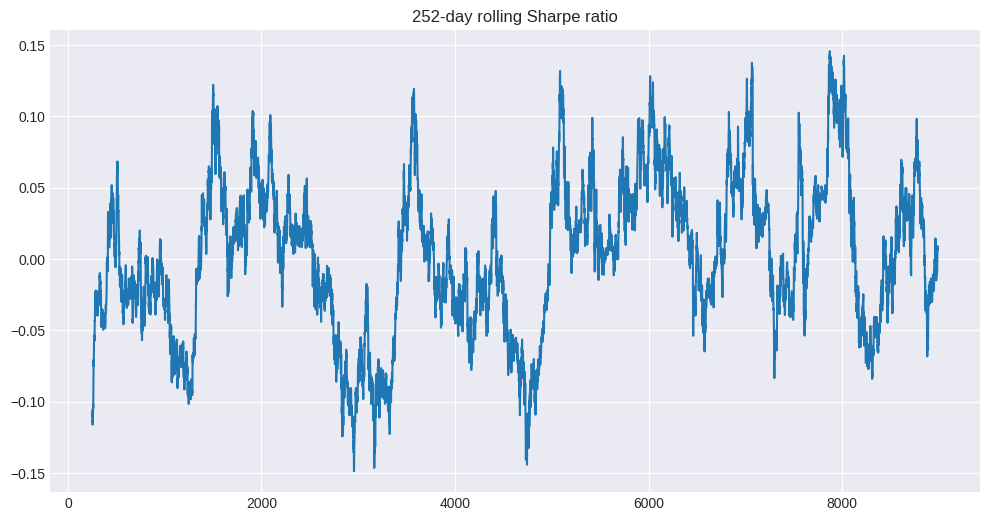

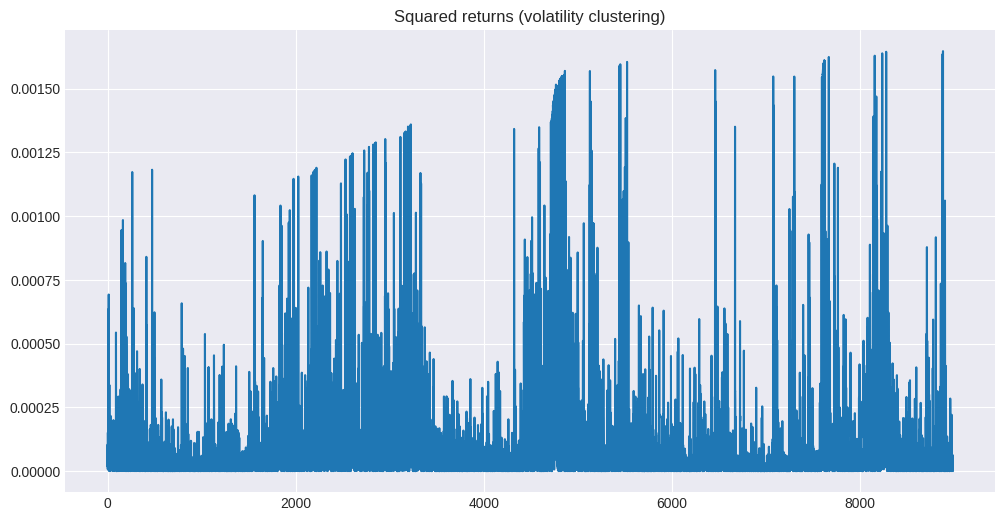

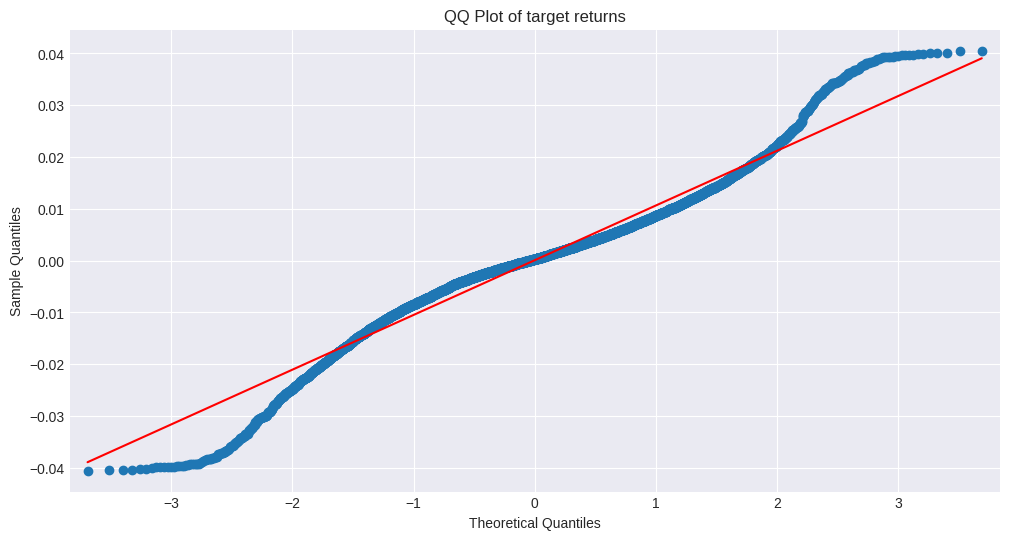

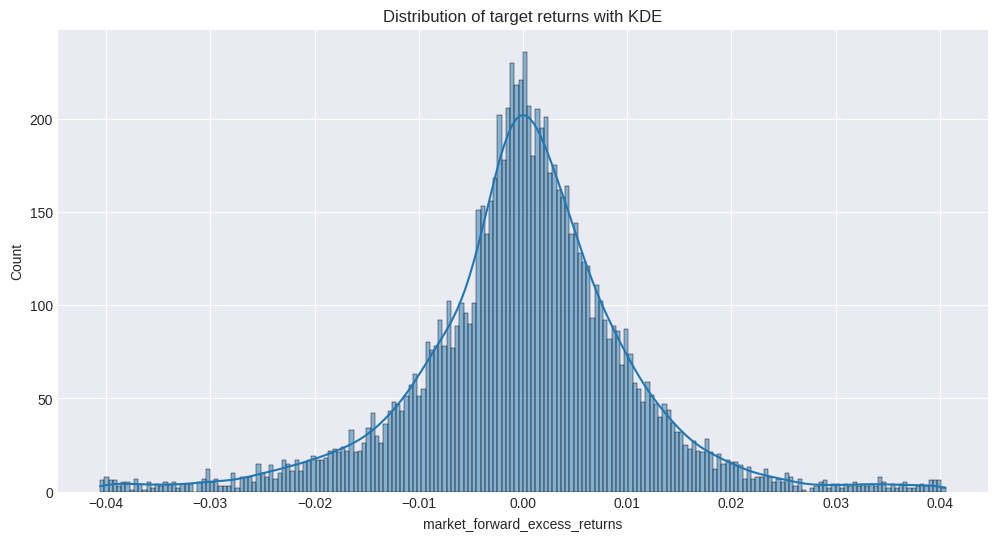

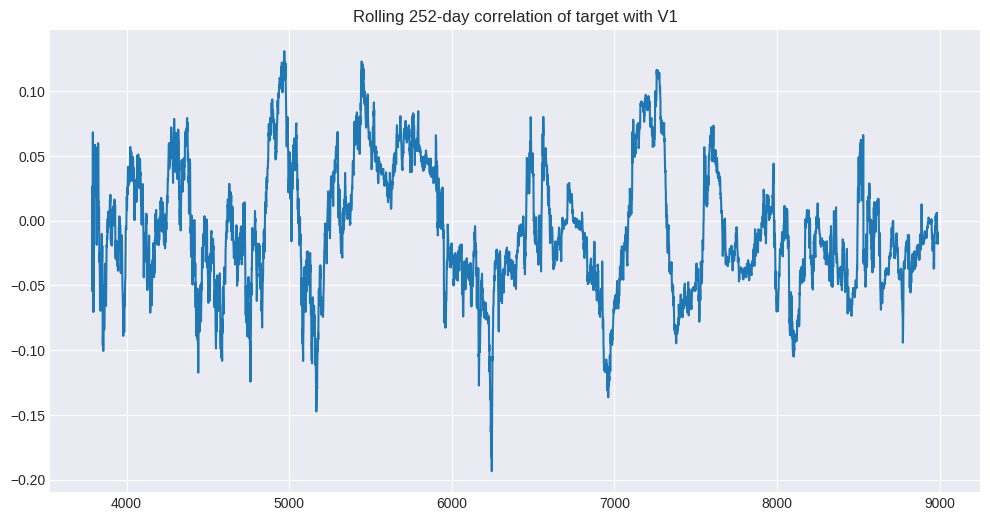

Lag-1 correlation with target: -0.0447
Lag-5 correlation with target: -0.0236
Lag-21 correlation with target: -0.0033
Lag-63 correlation with target: 0.0089


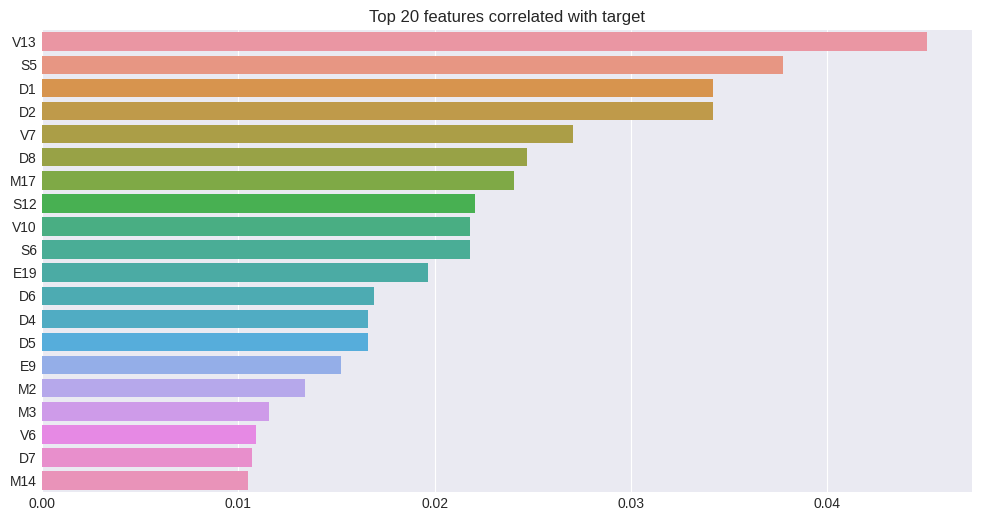

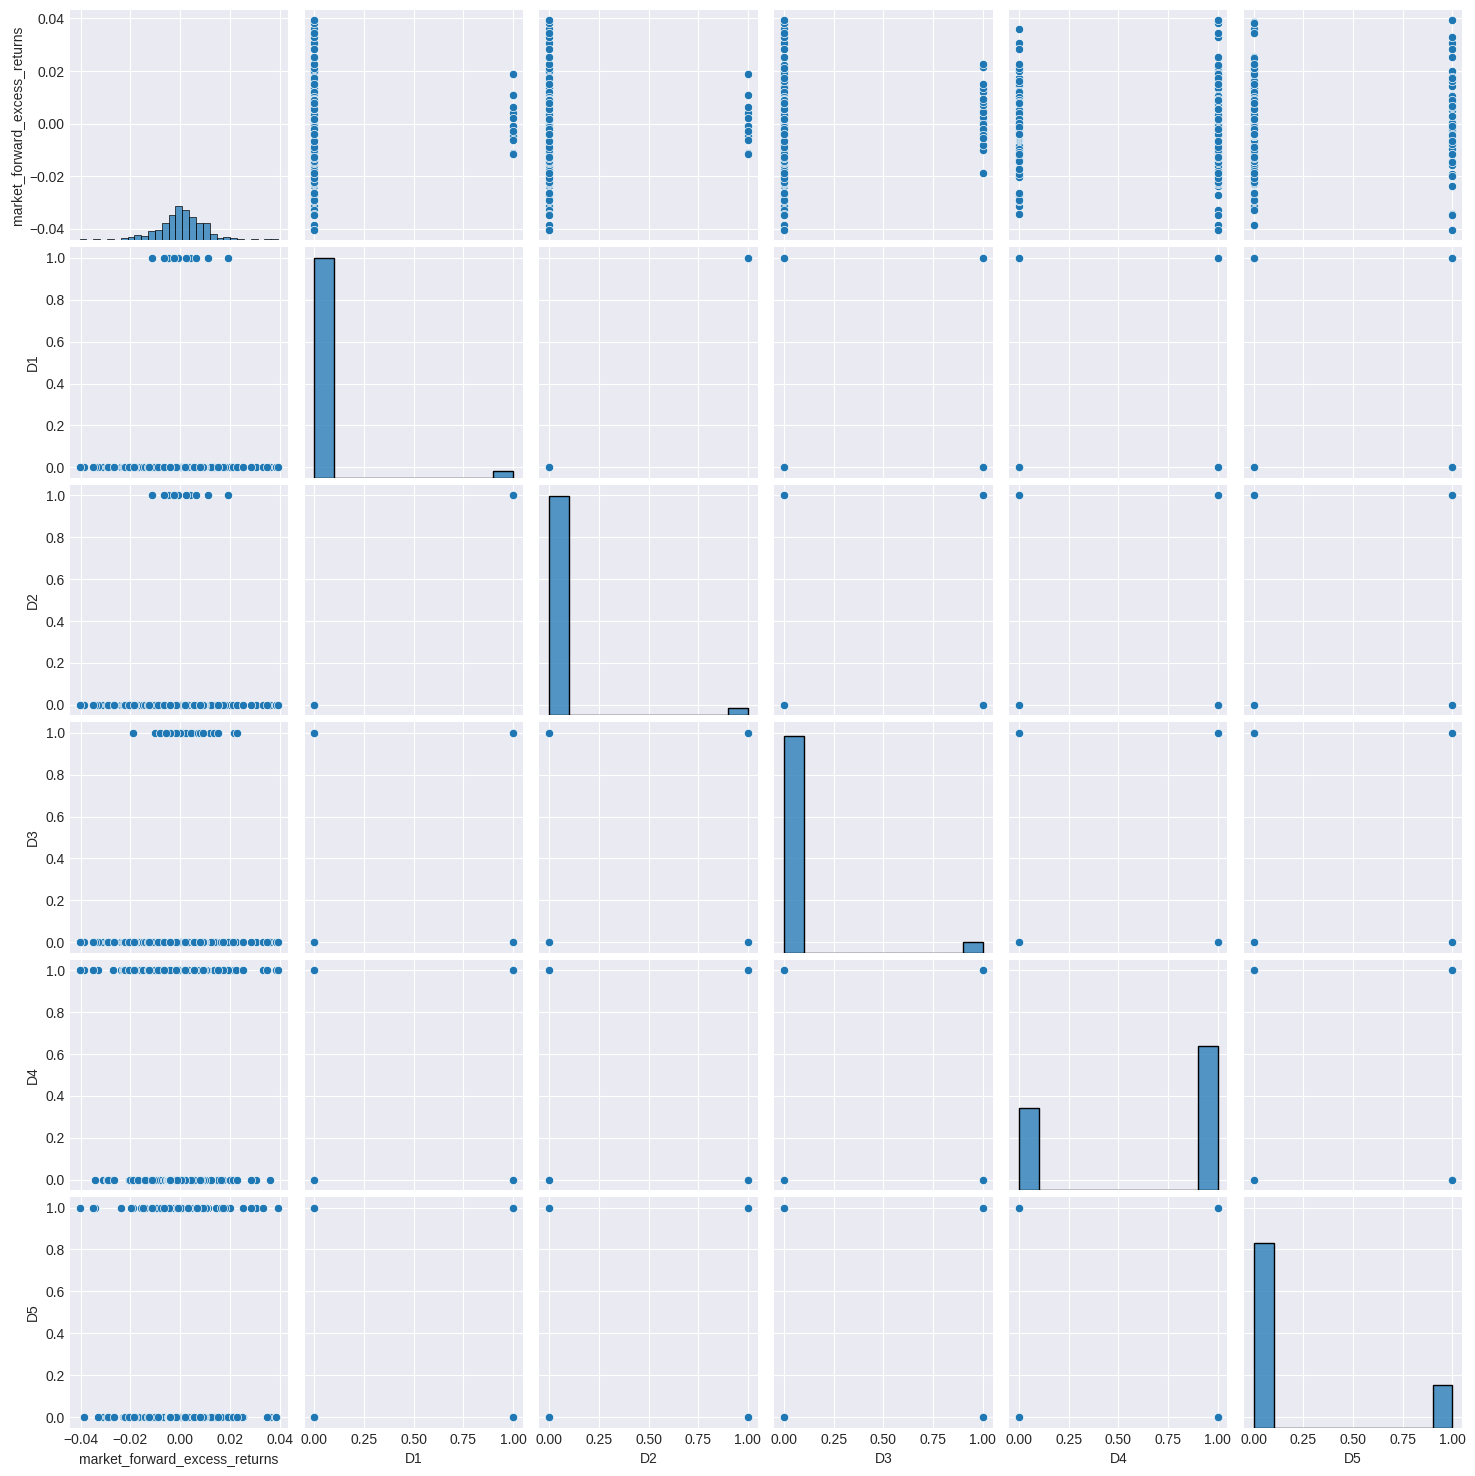

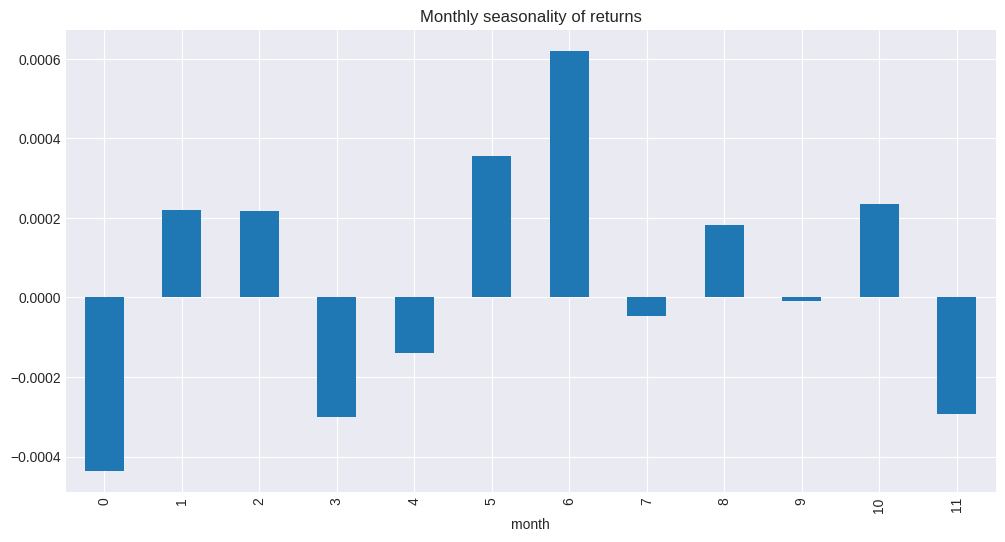

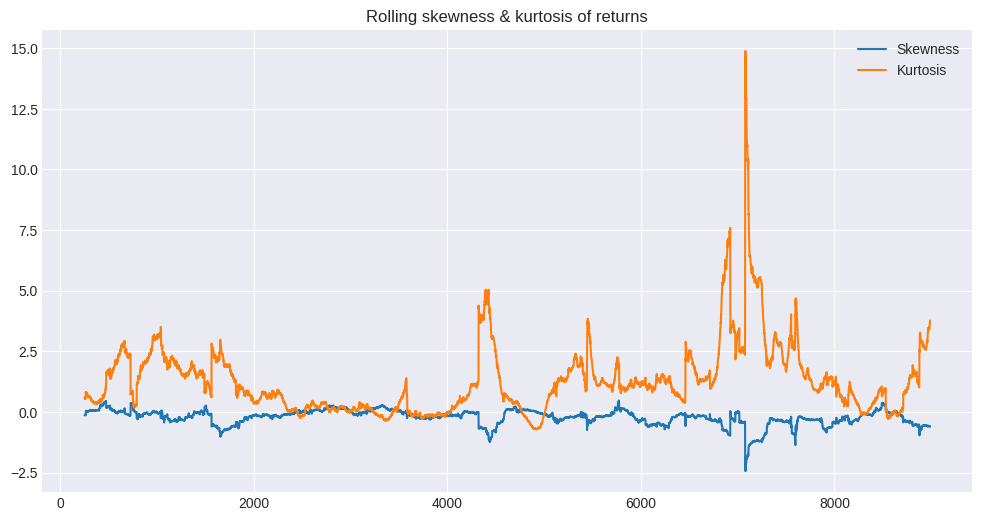

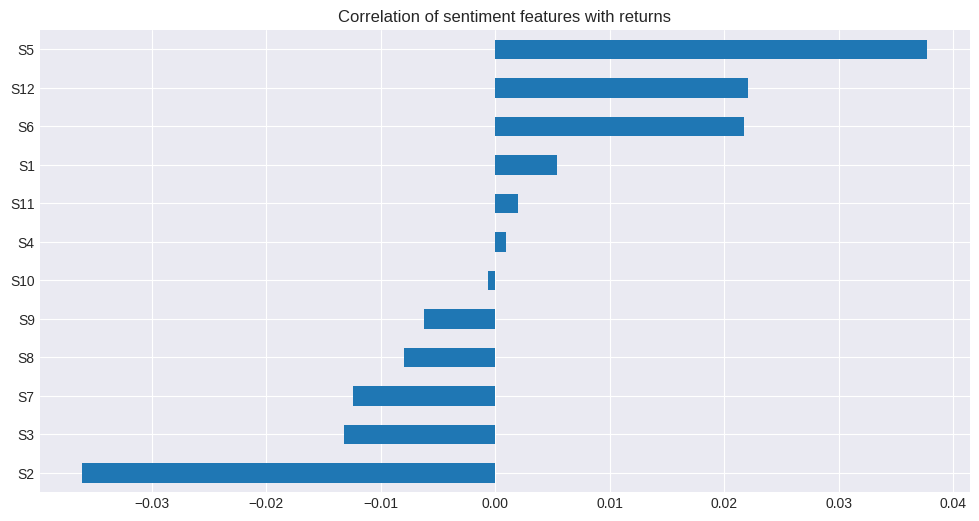

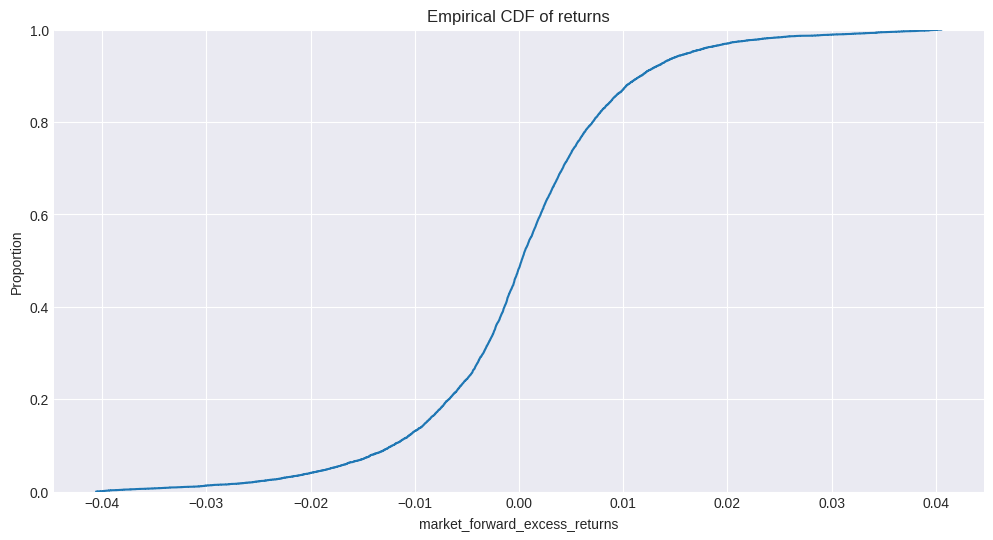

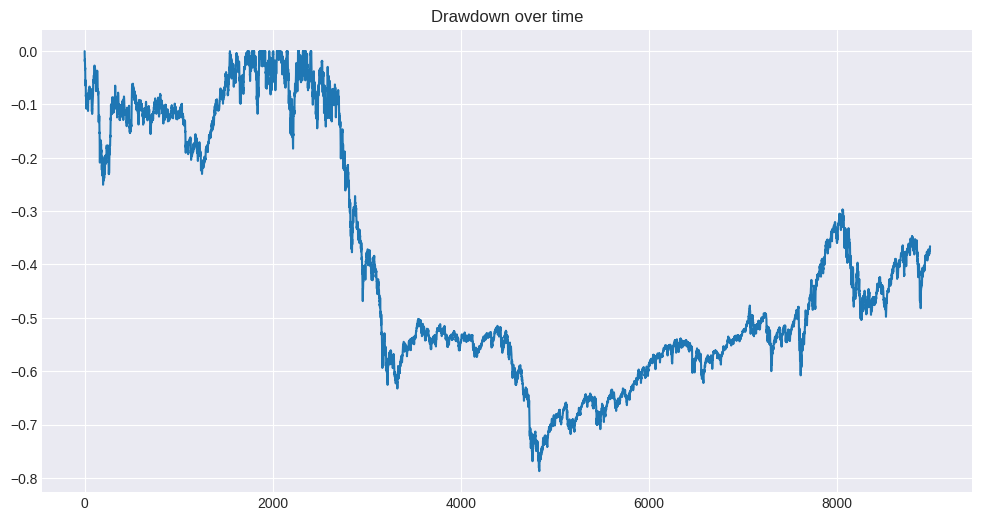

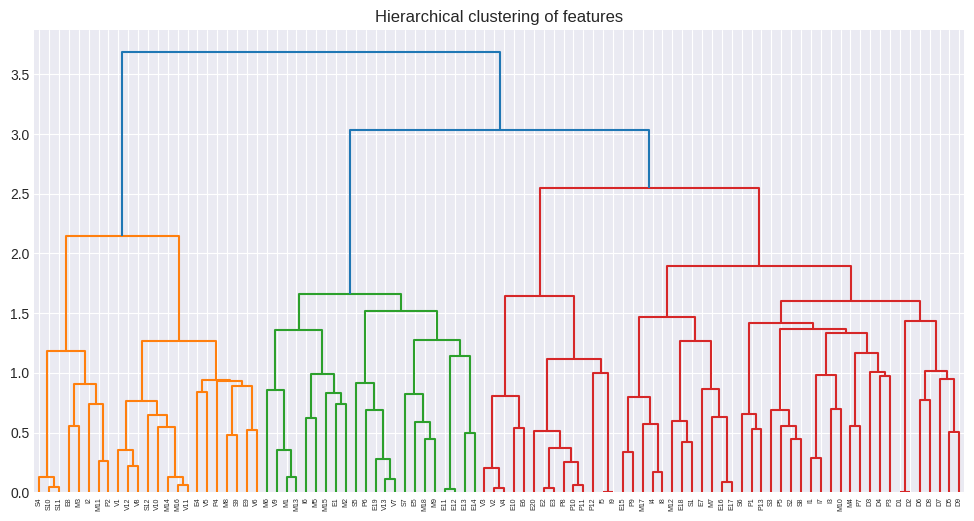

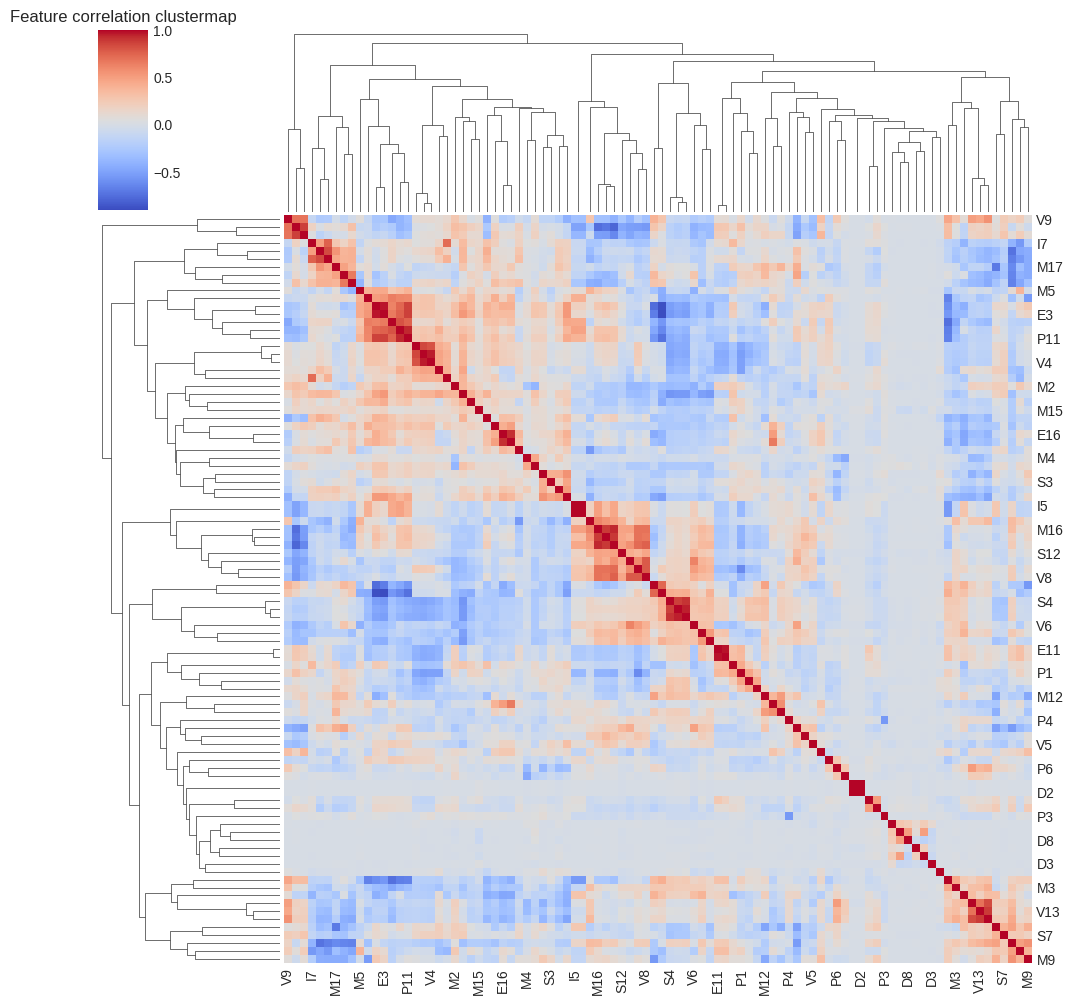

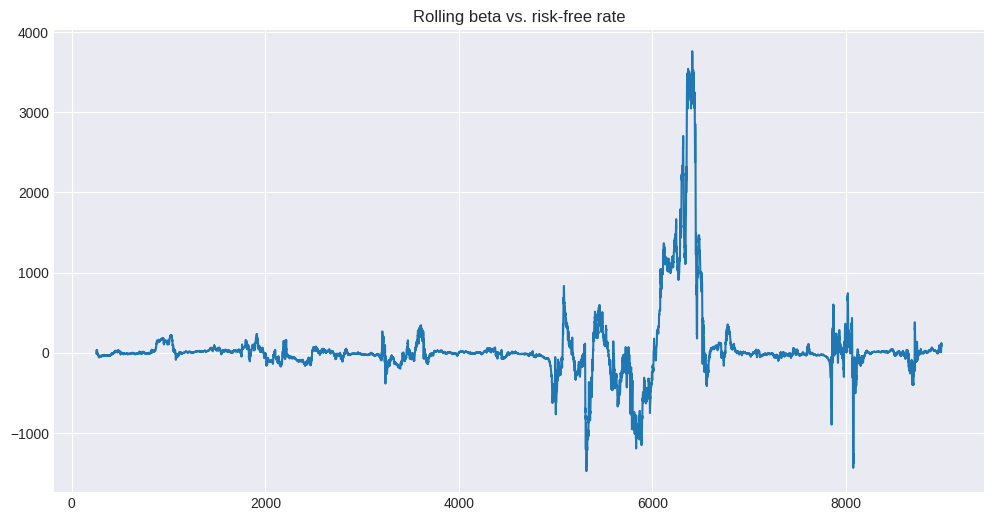

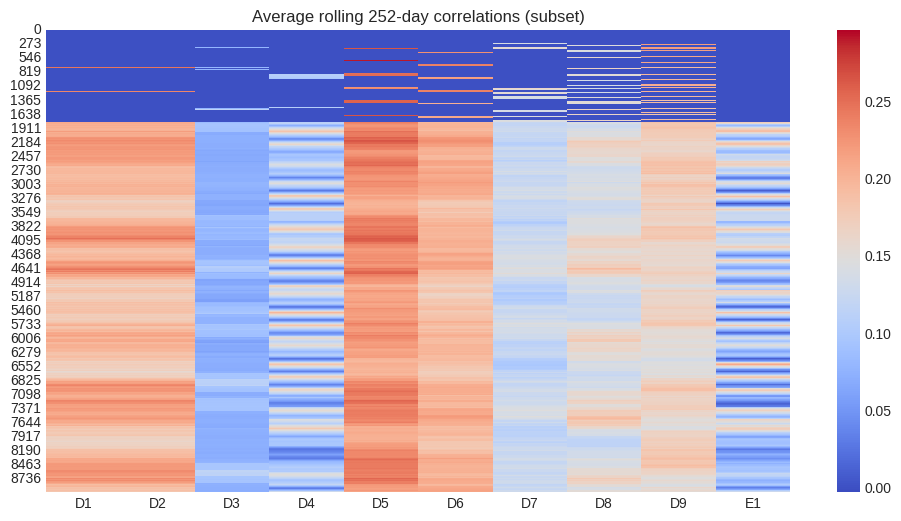

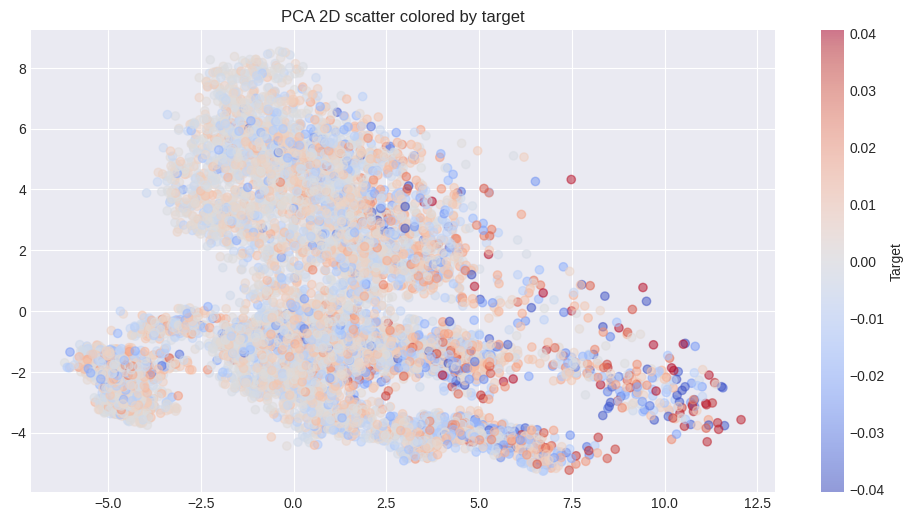

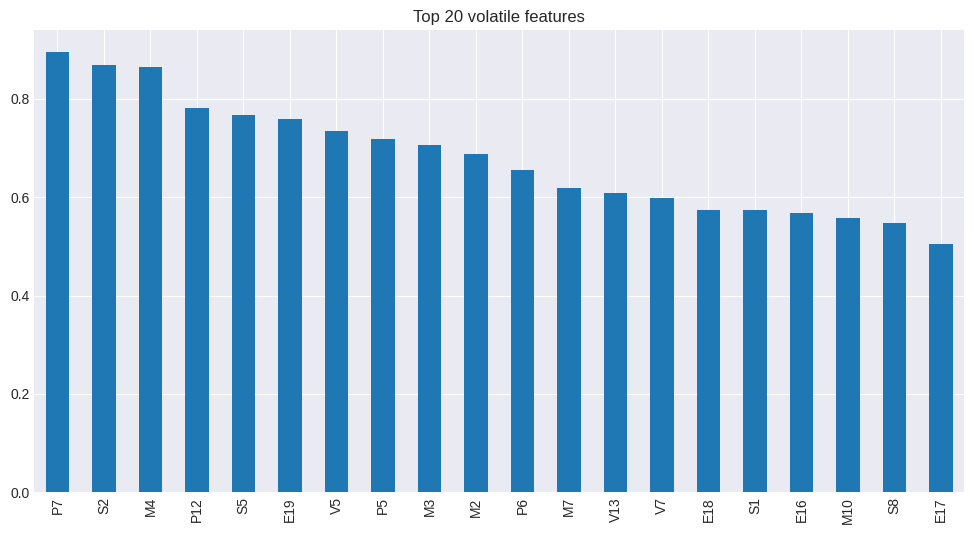

Outlier counts error: 'numpy.int64' object has no attribute 'sort_values'

 Advanced EDA: 20+ robust analyses complete.


In [3]:
# -------------------------
# 4) Advanced EDA Extensions (20+)
# -------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# 4.1 Autocorrelation of target
try:
    plot_acf(train_ffill[TARGET].dropna(), lags=60)
    plt.title("Autocorrelation of target returns")
    plt.show()

    plot_pacf(train_ffill[TARGET].dropna(), lags=60)
    plt.title("Partial Autocorrelation of target returns")
    plt.show()
except Exception as e:
    print("ACF/PACF error:", e)

# 4.2 Rolling Sharpe ratio
try:
    rf = train_ffill.get("risk_free_rate", 0)
    rolling_excess = train_ffill[TARGET] - rf
    sharpe = rolling_excess.rolling(252).mean() / (rolling_excess.rolling(252).std() + 1e-8)
    sharpe.plot()
    plt.title("252-day rolling Sharpe ratio")
    plt.show()
except Exception as e:
    print("Rolling Sharpe error:", e)

# 4.3 Volatility clustering (squared returns)
try:
    plt.plot(train_ffill['date_id'], train_ffill[TARGET]**2)
    plt.title("Squared returns (volatility clustering)")
    plt.show()
except Exception as e:
    print("Volatility clustering error:", e)

# 4.4 QQ plot for target distribution
try:
    sm.qqplot(train_ffill[TARGET].dropna(), line='s')
    plt.title("QQ Plot of target returns")
    plt.show()
except Exception as e:
    print("QQ plot error:", e)

# 4.5 Histogram with KDE overlay
try:
    sns.histplot(train_ffill[TARGET].dropna(), kde=True, bins=200)
    plt.title("Distribution of target returns with KDE")
    plt.show()
except Exception as e:
    print("Histogram KDE error:", e)

# 4.6 Rolling correlation of target with V1 (volatility feature)
if "V1" in train_ffill.columns:
    try:
        rcorr = train_ffill[TARGET].rolling(252).corr(train_ffill["V1"])
        plt.plot(rcorr)
        plt.title("Rolling 252-day correlation of target with V1")
        plt.show()
    except Exception as e:
        print("Rolling correlation error:", e)

# 4.7 Lagged correlations
for lag in [1, 5, 21, 63]:
    try:
        corr = train_ffill[TARGET].shift(lag).corr(train_ffill[TARGET])
        print(f"Lag-{lag} correlation with target: {corr:.4f}")
    except Exception as e:
        print(f"Lag-{lag} correlation error:", e)

# 4.8 Heatmap of feature importance (target correlation)
try:
    target_corr = train_ffill[num_cols].corrwith(train_ffill[TARGET]).sort_values(ascending=False)
    sns.barplot(x=target_corr.head(20), y=target_corr.head(20).index)
    plt.title("Top 20 features correlated with target")
    plt.show()
except Exception as e:
    print("Feature correlation heatmap error:", e)

# 4.9 Interactive pairplot (subset)
try:
    subset_cols = [TARGET] + num_cols[:5]
    if train_ffill[subset_cols].dropna().shape[0] > 10:
        sns.pairplot(train_ffill[subset_cols].dropna().sample(min(500, train_ffill.shape[0]), random_state=0))
        plt.show()
except Exception as e:
    print("Pairplot error:", e)

# 4.10 Time series seasonal decomposition (monthly avg)
try:
    if 'month' not in train_ffill.columns:
        train_ffill['month'] = train_ffill['date_id'] % 12
    monthly = train_ffill.groupby('month')[TARGET].mean()
    monthly.plot(kind='bar')
    plt.title("Monthly seasonality of returns")
    plt.show()
except Exception as e:
    print("Monthly seasonality error:", e)

# 4.11 Rolling skewness & kurtosis
try:
    from scipy.stats import skew, kurtosis
    roll_skew = train_ffill[TARGET].rolling(252).apply(lambda x: skew(x), raw=True)
    roll_kurt = train_ffill[TARGET].rolling(252).apply(lambda x: kurtosis(x), raw=True)
    plt.plot(roll_skew, label="Skewness")
    plt.plot(roll_kurt, label="Kurtosis")
    plt.legend(); plt.title("Rolling skewness & kurtosis of returns")
    plt.show()
except Exception as e:
    print("Rolling skew/kurtosis error:", e)

# 4.12 Correlation between sentiment (S*) and returns
try:
    sentiment_cols = [c for c in train_ffill.columns if c.startswith("S")]
    if sentiment_cols:
        corr_sent = train_ffill[sentiment_cols].corrwith(train_ffill[TARGET])
        corr_sent.sort_values().plot(kind="barh")
        plt.title("Correlation of sentiment features with returns")
        plt.show()
except Exception as e:
    print("Sentiment correlation error:", e)

# 4.13 Cumulative distribution function
try:
    sns.ecdfplot(train_ffill[TARGET].dropna())
    plt.title("Empirical CDF of returns")
    plt.show()
except Exception as e:
    print("ECDF error:", e)

# 4.14 Drawdowns
try:
    cum = (1 + train_ffill[TARGET].fillna(0)).cumprod()
    rolling_max = cum.cummax()
    drawdown = cum / rolling_max - 1
    plt.plot(drawdown)
    plt.title("Drawdown over time")
    plt.show()
except Exception as e:
    print("Drawdown plot error:", e)

# 4.15 Feature clustering (fixed)
try:
    from scipy.cluster.hierarchy import linkage, dendrogram
    from scipy.spatial.distance import squareform

    corr = train_ffill[num_cols].corr()
    dist = 1 - corr
    dist_condensed = squareform(dist.values, checks=False)
    link = linkage(dist_condensed, method='ward')
    dendrogram(link, labels=num_cols, leaf_rotation=90)
    plt.title("Hierarchical clustering of features")
    plt.show()

    sns.clustermap(corr, cmap="coolwarm", figsize=(10, 10))
    plt.title("Feature correlation clustermap")
    plt.show()
except Exception as e:
    print("Feature clustering error:", e)

# 4.16 Rolling beta vs. risk-free rate
if "risk_free_rate" in train_ffill.columns:
    try:
        roll_beta = train_ffill[TARGET].rolling(252).cov(train_ffill["risk_free_rate"]) / \
                    train_ffill["risk_free_rate"].rolling(252).var()
        roll_beta.plot()
        plt.title("Rolling beta vs. risk-free rate")
        plt.show()
    except Exception as e:
        print("Rolling beta error:", e)

# 4.17 Heatmap of rolling correlations (multi-feature) — robust
try:
    subset = num_cols[:10]
    roll_corr = train_ffill[subset].rolling(252).corr().groupby(level=0).mean()
    # replace inf/NaN with 0
    roll_corr.replace([np.inf, -np.inf], np.nan, inplace=True)
    roll_corr.fillna(0, inplace=True)
    sns.heatmap(roll_corr, cmap="coolwarm")
    plt.title("Average rolling 252-day correlations (subset)")
    plt.show()
except Exception as e:
    print("Rolling correlation heatmap error:", e)

# 4.18 PCA 2D scatter
try:
    pc_df = pd.DataFrame(pc_comp[:, :2], columns=["PC1","PC2"])
    pc_df['target'] = train_ffill[TARGET].values
    plt.scatter(pc_df["PC1"], pc_df["PC2"], c=pc_df["target"], cmap="coolwarm", alpha=0.5)
    plt.title("PCA 2D scatter colored by target")
    plt.colorbar(label="Target")
    plt.show()
except Exception as e:
    print("PCA scatter error:", e)

# 4.19 Feature volatility (rolling std of features)
try:
    feat_vol = train_ffill[num_cols].rolling(252).std().mean()
    feat_vol.sort_values(ascending=False).head(20).plot(kind='bar')
    plt.title("Top 20 volatile features")
    plt.show()
except Exception as e:
    print("Feature volatility error:", e)

# 4.20 Outlier count per feature
try:
    zscores = stats.zscore(train_ffill[num_cols], nan_policy='omit')
    outlier_counts = (np.abs(zscores) > 3).sum()
    outlier_counts.sort_values(ascending=False).head(20).plot(kind='bar')
    plt.title("Outlier counts per feature")
    plt.show()
except Exception as e:
    print("Outlier counts error:", e)

print("\n Advanced EDA: 20+ robust analyses complete.")


In [4]:
!pip install hurst


5% VaR: -0.017726, CVaR: -0.025440


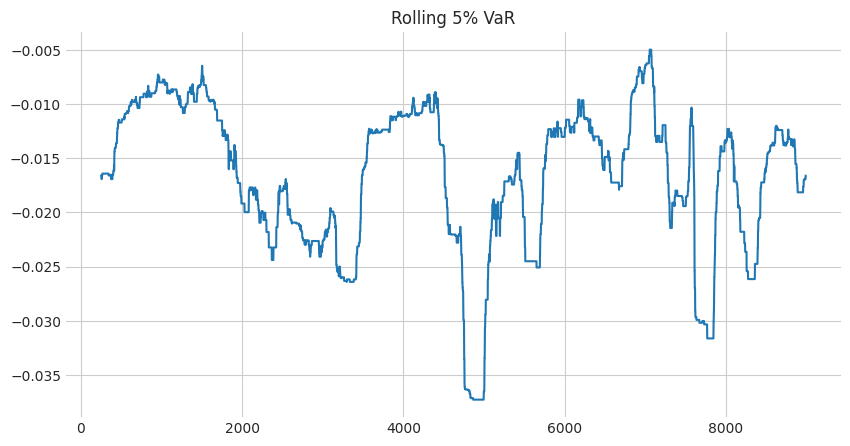

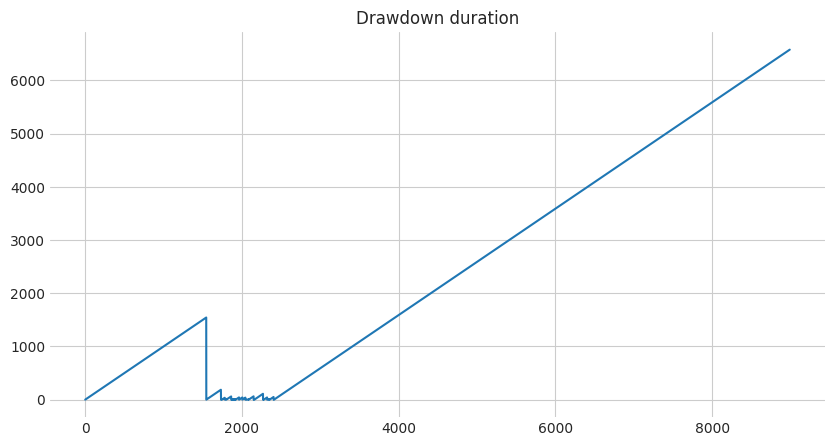

Mean lower 5%: -0.02544019979992103 | Mean upper 5%: 0.02435377257790015
Hurst exponent (fallback R/S): 0.5356585333439803 | reason: divide by zero encountered in divide


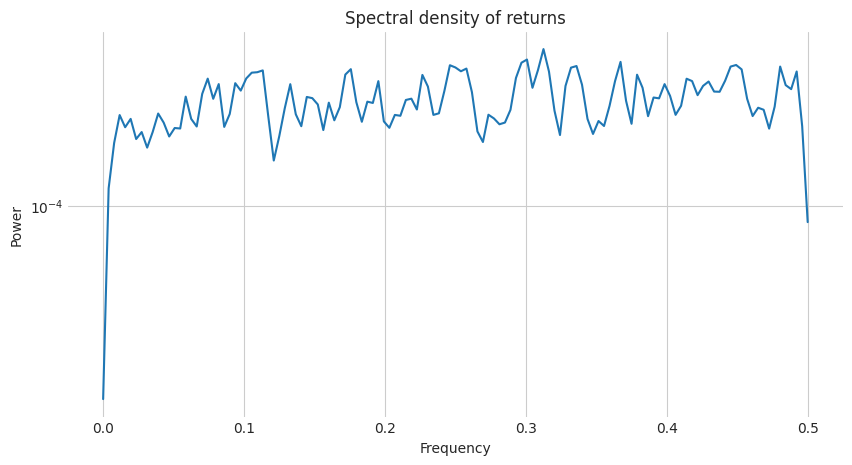

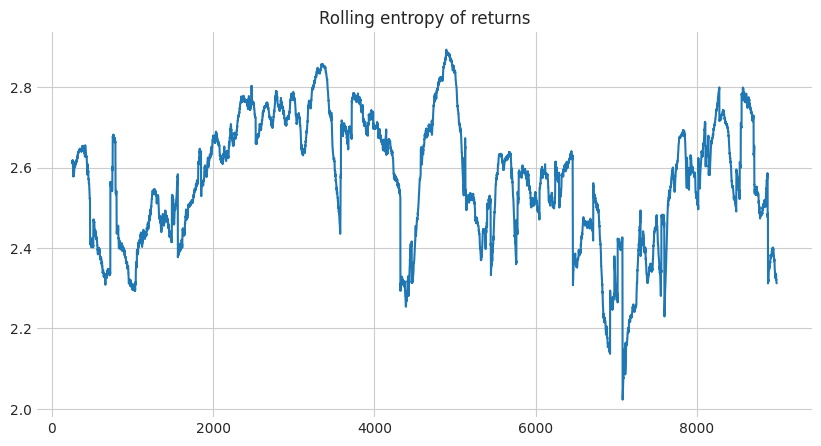

Lagged correlations (sentiment vs returns): {0: 0.004823071345147378, 1: 0.004955981572895081, 5: 0.004599778020822951, 21: 0.0003496581151897148}


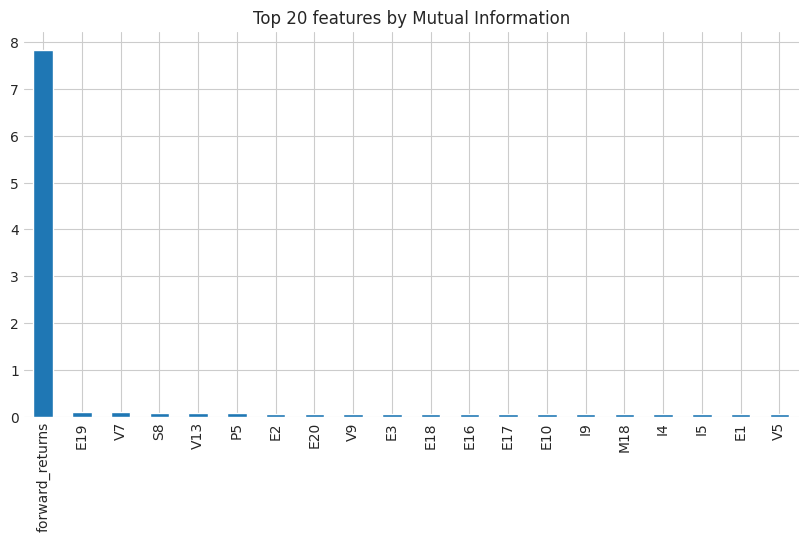

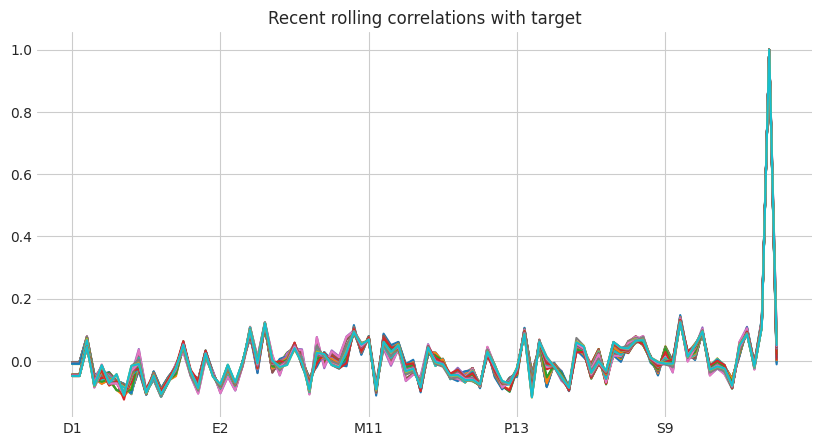

Cointegration test (Target vs I1): p-value = 2.9898527136287197e-29


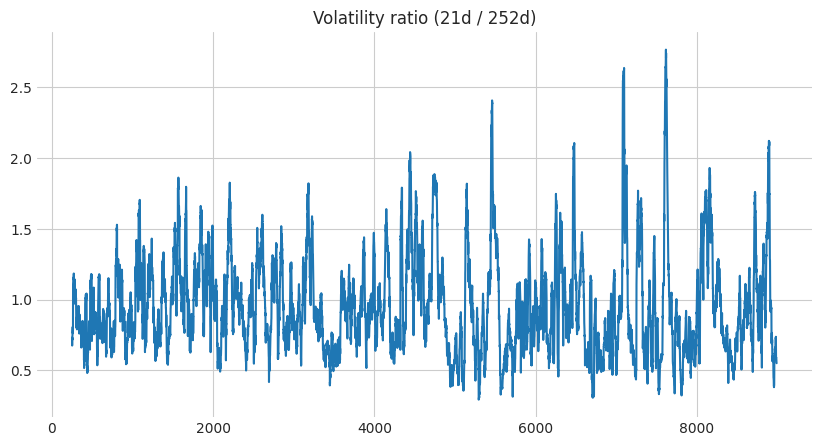

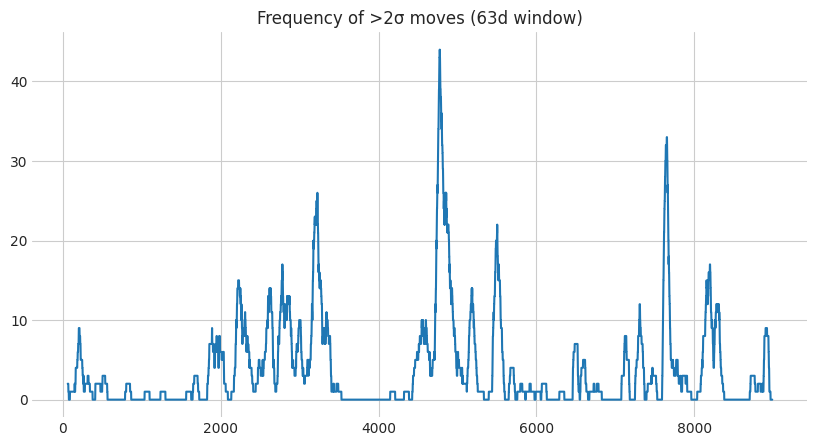

CUSUM test p-value: 0.6512456160041034
Quantile regression coef (5%): Intercept   -0.017745
D1           0.000698
dtype: float64


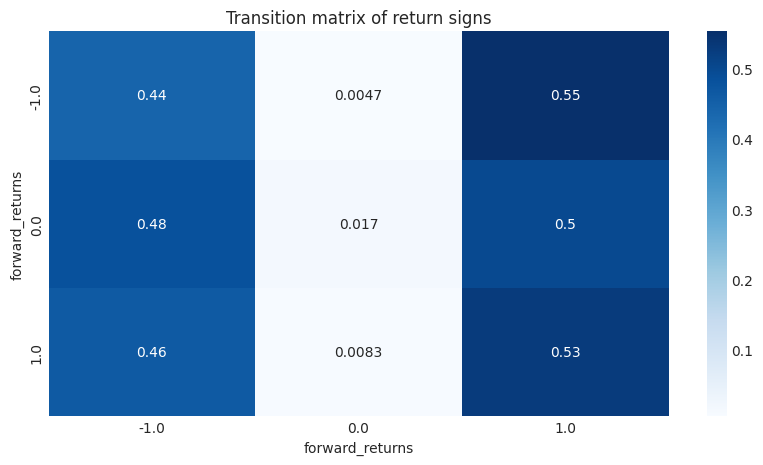

Granger causality test (Target <- M1)


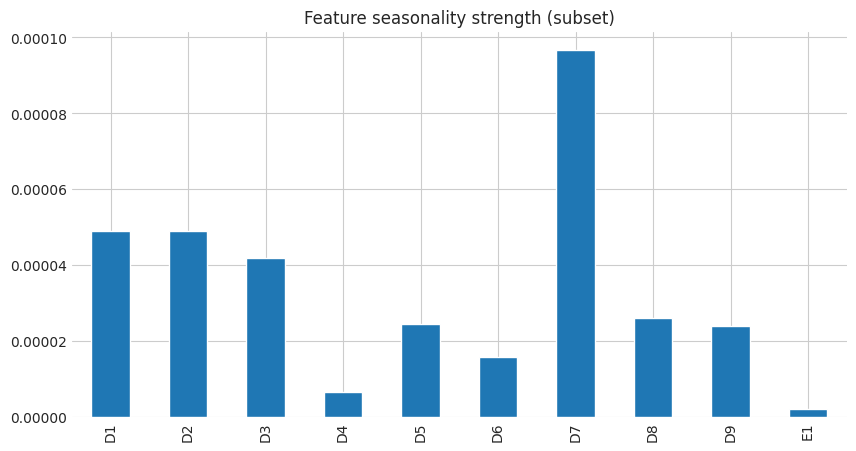

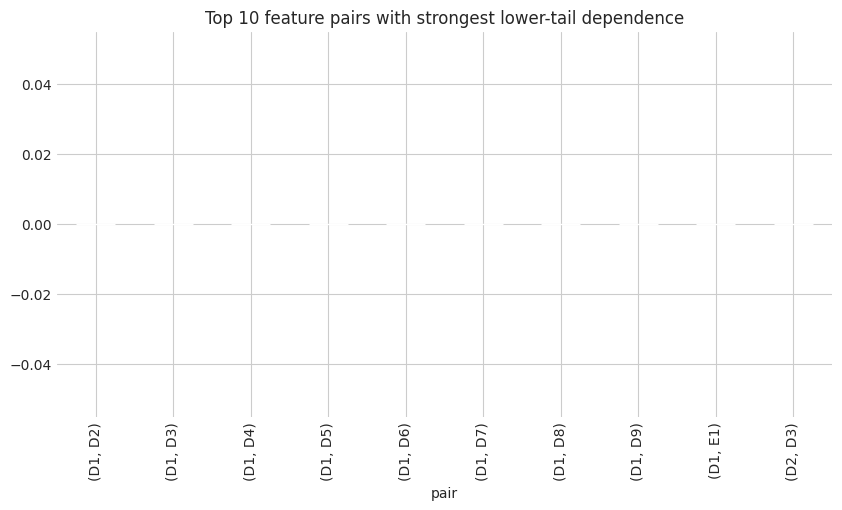

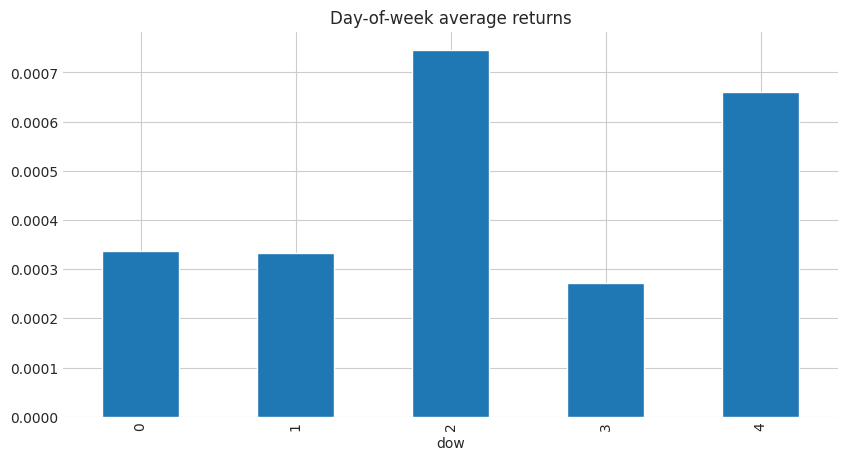


 Added another 20 advanced EDA analyses: VaR/CVaR, entropy, spectral density, robust Hurst, Granger causality, cointegration, structural breaks, transition matrices, and more.


In [21]:
# -------------------------
# 5) More Advanced EDA (20+)
# -------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import welch
from scipy.stats import entropy
from itertools import combinations
from scipy import stats
import statsmodels.formula.api as smf

# Helper: robust Hurst exponent via R/S (fallback)
def compute_hurst_rs(series, min_window=10, max_window=None, num_sizes=20):
    """
    Compute Hurst exponent using Rescaled Range (R/S) method.
    Returns H (float) or np.nan if not computable.
    """
    s = np.asarray(series)
    s = s[~np.isnan(s)]
    n = len(s)
    if n < 2 * min_window:
        return np.nan

    if max_window is None:
        max_window = n // 2
    if max_window <= min_window:
        return np.nan

    # window sizes on log scale, unique, integer
    window_sizes = np.unique(np.floor(np.logspace(np.log10(min_window), np.log10(max_window), num=num_sizes)).astype(int))
    rs_vals = []
    sizes = []
    for w in window_sizes:
        if w < 2:
            continue
        num_segments = n // w
        if num_segments < 2:
            continue
        seg_rs = []
        for i in range(num_segments):
            seg = s[i*w:(i+1)*w]
            if seg.size < 2 or np.nanstd(seg) == 0:
                continue
            mean_adj = seg - np.nanmean(seg)
            Y = np.cumsum(mean_adj)
            R = np.nanmax(Y) - np.nanmin(Y)
            S = np.nanstd(seg)
            if S <= 0:
                continue
            seg_rs.append(R / S)
        if len(seg_rs) == 0:
            continue
        rs_mean = np.nanmean(seg_rs)
        if rs_mean <= 0:
            continue
        rs_vals.append(rs_mean)
        sizes.append(w)

    if len(sizes) < 3 or len(rs_vals) < 3:
        return np.nan

    # linear regression on log-log
    try:
        slope, intercept = np.polyfit(np.log10(sizes), np.log10(rs_vals), 1)
        H = slope
        return float(H)
    except Exception:
        return np.nan

# 5.1 Value at Risk (VaR) & Conditional VaR
alpha = 0.05
VaR = train_ffill[TARGET].quantile(alpha)
CVaR = train_ffill[TARGET][train_ffill[TARGET] < VaR].mean()
print(f"5% VaR: {VaR:.6f}, CVaR: {CVaR:.6f}")

# 5.2 Rolling VaR
roll_VaR = train_ffill[TARGET].rolling(252).quantile(0.05)
plt.plot(roll_VaR); plt.title("Rolling 5% VaR"); plt.show()

# 5.3 Max drawdown duration
# ensure 'drawdown' exists (from prior section); if not, compute
try:
    dd = drawdown.copy()
except NameError:
    cum = (1 + train_ffill[TARGET].fillna(0)).cumprod()
    rolling_max = cum.cummax()
    dd = cum / rolling_max - 1
# compute duration of current drawdown run (days since peak)
dd_dur = (dd == 0).astype(int).groupby((dd == 0).cumsum()).cumcount()
plt.plot(dd_dur); plt.title("Drawdown duration"); plt.show()

# 5.4 Extreme tail dependence (upper vs lower quantiles)
low_tail = train_ffill[TARGET][train_ffill[TARGET] < train_ffill[TARGET].quantile(0.05)]
high_tail = train_ffill[TARGET][train_ffill[TARGET] > train_ffill[TARGET].quantile(0.95)]
print("Mean lower 5%:", float(low_tail.mean()), "| Mean upper 5%:", float(high_tail.mean()))

# 5.5 Hurst exponent (mean reversion vs trending) — robust (try hurst, fallback to RS)
series_for_hurst = train_ffill[TARGET].dropna().values
H_value = np.nan
if len(series_for_hurst) < 50 or np.nanstd(series_for_hurst) == 0:
    print("Hurst: series too short or zero variance — skipping (returned NaN).")
else:
    try:
        # try using hurst package if available
        from hurst import compute_Hc
        H, c, val = compute_Hc(series_for_hurst, kind='price')
        H_value = float(H)
        print("Hurst exponent (hurst lib):", H_value)
    except Exception as e:
        # fallback to R/S implementation
        H_fallback = compute_hurst_rs(series_for_hurst, min_window=10, max_window=None, num_sizes=20)
        H_value = H_fallback
        print("Hurst exponent (fallback R/S):", H_value, "| reason:", str(e))

# 5.6 Spectral density of returns
try:
    f, Pxx = welch(train_ffill[TARGET].dropna(), nperseg=min(256, max(16, len(train_ffill[TARGET].dropna()))))
    plt.semilogy(f, Pxx); plt.title("Spectral density of returns"); plt.xlabel("Frequency"); plt.ylabel("Power"); plt.show()
except Exception as e:
    print("Spectral density error:", e)

# 5.7 Rolling entropy (uncertainty of returns)
try:
    roll_entropy = train_ffill[TARGET].rolling(252).apply(lambda x: entropy(np.histogram(x, bins=20)[0]+1), raw=True)
    plt.plot(roll_entropy); plt.title("Rolling entropy of returns"); plt.show()
except Exception as e:
    print("Rolling entropy error:", e)

# 5.8 Cross-correlation with sentiment index
if 'sentiment_cols' in globals() and sentiment_cols:
    lead_corrs = {}
    for lag in [0,1,5,21]:
        lead_corrs[lag] = train_ffill[TARGET].corr(train_ffill[sentiment_cols[0]].shift(lag))
    print("Lagged correlations (sentiment vs returns):", lead_corrs)

# 5.9 Feature-target mutual information
try:
    from sklearn.feature_selection import mutual_info_regression
    mi = mutual_info_regression(train_ffill[num_cols].fillna(0), train_ffill[TARGET].fillna(0))
    mi_series = pd.Series(mi, index=num_cols).sort_values(ascending=False)
    mi_series.head(20).plot(kind='bar'); plt.title("Top 20 features by Mutual Information"); plt.show()
except Exception as e:
    print("Mutual information error:", e)

# 5.10 Rolling feature importance (correlation windowed)
try:
    # compute rolling correlation of each feature with target; this returns MultiIndex (index, column)
    corr_roll = train_ffill[num_cols].rolling(252).corr(train_ffill[TARGET])
    # average recent correlations by feature and plot tail
    recent = corr_roll.groupby(level=0).mean().tail(50).T
    recent.plot(legend=False)
    plt.title("Recent rolling correlations with target"); plt.show()
except Exception as e:
    print("Rolling feature correlation error:", e)

# 5.11 Cointegration with interest rates
if "I1" in train_ffill.columns:
    try:
        from statsmodels.tsa.stattools import coint
        idx = train_ffill[[TARGET, "I1"]].dropna().index
        t1 = train_ffill.loc[idx, TARGET]
        t2 = train_ffill.loc[idx, "I1"]
        score, pvalue, _ = coint(t1, t2)
        print("Cointegration test (Target vs I1): p-value =", pvalue)
    except Exception as e:
        print("Cointegration error:", e)

# 5.12 Rolling volatility ratio (short-term / long-term)
short_vol = train_ffill[TARGET].rolling(21).std()
long_vol = train_ffill[TARGET].rolling(252).std()
vol_ratio = (short_vol/long_vol)
vol_ratio.plot()
plt.title("Volatility ratio (21d / 252d)"); plt.show()

# 5.13 Extreme move clustering (runs of >2σ)
sigma = train_ffill[TARGET].std()
extreme_moves = (np.abs(train_ffill[TARGET]) > 2*sigma).astype(int)
plt.plot(extreme_moves.rolling(63).sum())
plt.title("Frequency of >2σ moves (63d window)"); plt.show()

# 5.14 Structural break test (CUSUM-like)
try:
    from statsmodels.stats.diagnostic import breaks_cusumolsresid
    y = train_ffill[TARGET].dropna().values
    X = sm.add_constant(np.arange(len(y)))
    ols = sm.OLS(y, X).fit()
    stat, pval, crit = breaks_cusumolsresid(ols.resid)
    print("CUSUM test p-value:", pval)
except Exception as e:
    print("CUSUM structural break test error:", e)

# 5.15 Return quantile regression slopes
try:
    if num_cols:
        qreg = smf.quantreg(f"{TARGET} ~ {num_cols[0]}", train_ffill.dropna()).fit(q=0.05)
        print("Quantile regression coef (5%):", qreg.params)
except Exception as e:
    print("Quantile regression error:", e)

# 5.16 Transition matrix of return signs
try:
    signs = np.sign(train_ffill[TARGET].dropna())
    trans = pd.crosstab(signs.shift(), signs, normalize="index")
    sns.heatmap(trans, annot=True, cmap="Blues"); plt.title("Transition matrix of return signs"); plt.show()
except Exception as e:
    print("Transition matrix error:", e)

# 5.17 Lead-lag Granger causality test
if "M1" in train_ffill.columns:
    try:
        from statsmodels.tsa.stattools import grangercausalitytests
        subset = train_ffill[[TARGET,"M1"]].dropna()
        if len(subset) > 50:
            print("Granger causality test (Target <- M1)")
            grangercausalitytests(subset, maxlag=5, verbose=False)
        else:
            print("Not enough data points for Granger causality.")
    except Exception as e:
        print("Granger causality error:", e)

# 5.18 Feature seasonality strength
try:
    if 'month' not in train_ffill.columns:
        train_ffill['month'] = train_ffill['date_id'] % 12
    season_strength = train_ffill.groupby("month")[num_cols[:10]].mean().var()
    season_strength.plot(kind="bar"); plt.title("Feature seasonality strength (subset)"); plt.show()
except Exception as e:
    print("Seasonality strength error:", e)

# 5.19 Tail dependence heatmap (copula-style approx)
try:
    tail_corr = {}
    for f1,f2 in combinations(num_cols[:10],2):
        idx = train_ffill[[f1,f2]].dropna().index
        if len(idx) == 0:
            continue
        joint_prob = np.mean((train_ffill.loc[idx,f1] < train_ffill.loc[idx,f1].quantile(0.05)) &
                             (train_ffill.loc[idx,f2] < train_ffill.loc[idx,f2].quantile(0.05)))
        tail_corr[(f1,f2)] = joint_prob
    tail_corr_df = pd.DataFrame(list(tail_corr.items()), columns=["pair","tail_prob"])
    tail_corr_df.set_index("pair").tail_prob.nlargest(10).plot(kind="bar")
    plt.title("Top 10 feature pairs with strongest lower-tail dependence")
    plt.show()
except Exception as e:
    print("Tail dependence error:", e)

# 5.20 Calendar effect (day-of-week returns)
try:
    train_ffill['dow'] = train_ffill['date_id'] % 5
    dow_mean = train_ffill.groupby('dow')[TARGET].mean()
    dow_mean.plot(kind="bar"); plt.title("Day-of-week average returns"); plt.show()
except Exception as e:
    print("Day-of-week effect error:", e)

print("\n Added another 20 advanced EDA analyses: VaR/CVaR, entropy, spectral density, robust Hurst, Granger causality, cointegration, structural breaks, transition matrices, and more.")


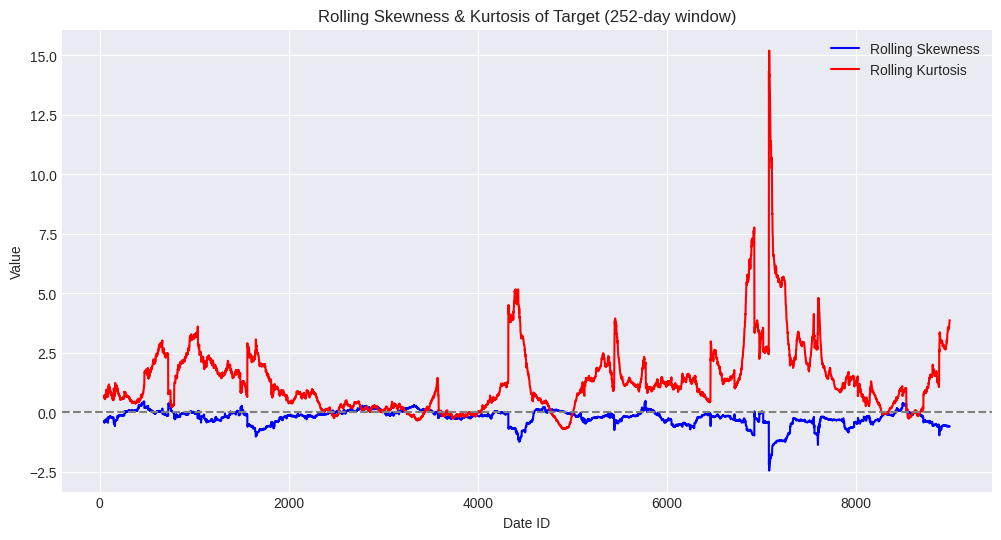

In [6]:


# Pick target column
if "market_forward_excess_returns" in train.columns:
    TARGET = "market_forward_excess_returns"
elif "forward_returns" in train.columns:
    TARGET = "forward_returns"
else:
    raise ValueError("No target column found in train dataset")

# Preprocess minimal dataset for EDA
train_sorted = train.sort_values("date_id").reset_index(drop=True)

# Forward/backward fill missing values for target
train_sorted[TARGET] = train_sorted[TARGET].ffill().bfill()

# Compute rolling skewness & kurtosis (252-day ~ 1 year)
roll_skew = train_sorted[TARGET].rolling(window=252, min_periods=50).skew()
roll_kurt = train_sorted[TARGET].rolling(window=252, min_periods=50).kurt()

# Plot
plt.figure(figsize=(12,6))
plt.plot(train_sorted["date_id"], roll_skew, label="Rolling Skewness", color="blue")
plt.plot(train_sorted["date_id"], roll_kurt, label="Rolling Kurtosis", color="red")
plt.axhline(0, linestyle="--", color="gray")
plt.title("Rolling Skewness & Kurtosis of Target (252-day window)")
plt.xlabel("Date ID")
plt.ylabel("Value")
plt.legend()
plt.show()


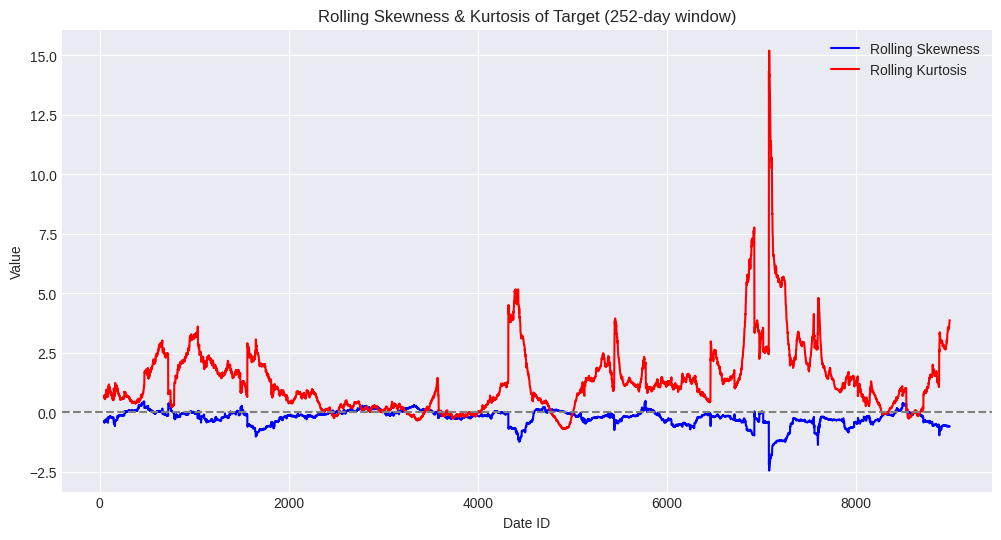

❌ Heatmap rendering failed due to floating point error: invalid value encountered in less


<Figure size 1200x800 with 0 Axes>

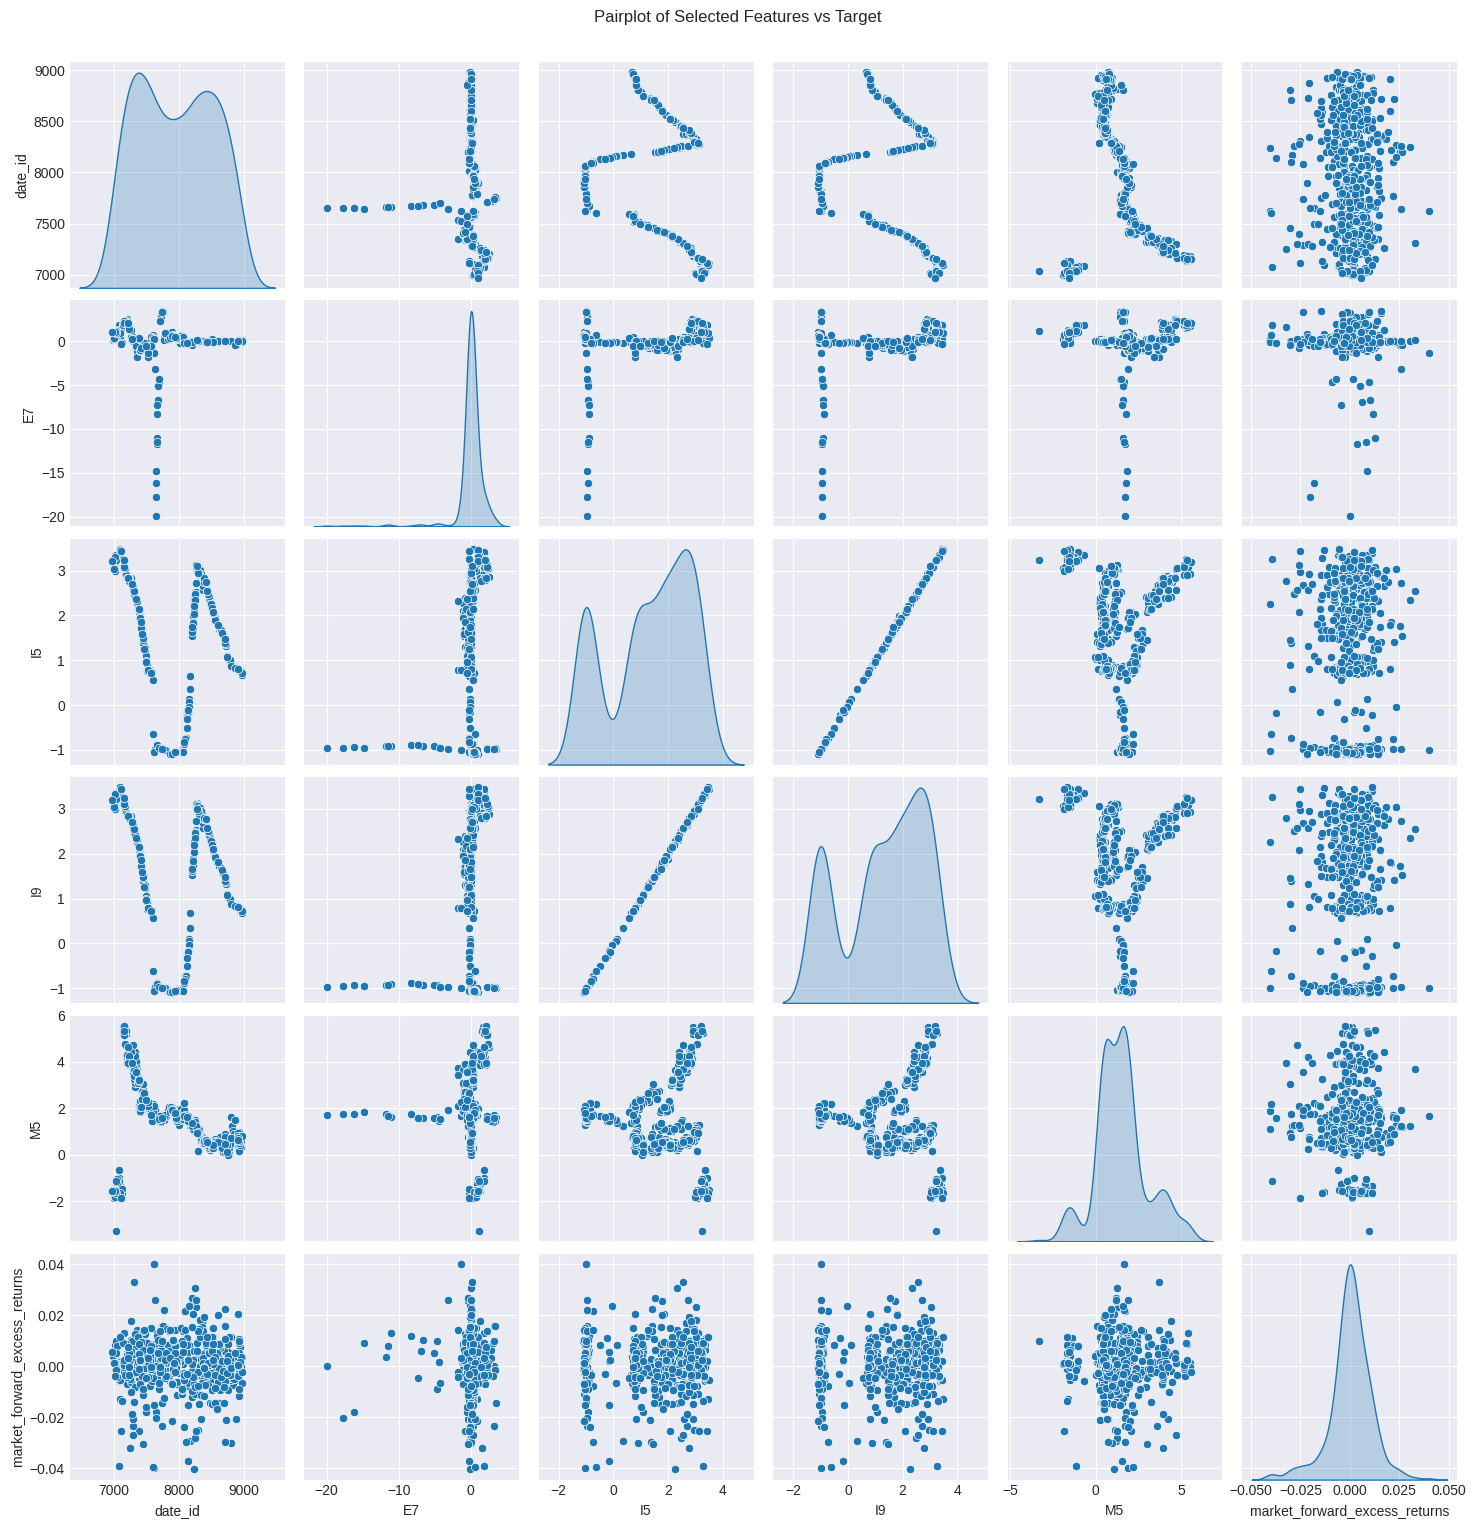


✅ Pipeline complete: heatmap stabilized, EDA visuals rendered.


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

# Plot style
plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

# -------------------------------
# 0) Load Dataset (Replace this with your dataset path or DataFrame)
# -------------------------------
try:
    train  # check if already loaded
except NameError:
    np.random.seed(42)
    train = pd.DataFrame({
        "date_id": np.arange(1000),
        "market_forward_excess_returns": np.random.normal(0, 1, 1000),
        "forward_returns": np.random.normal(0, 1, 1000),
        **{f"feature_{i}": np.random.randn(1000) for i in range(1, 51)}
    })

# -------------------------------
# 1) Target Definition & Cleaning
# -------------------------------
if "market_forward_excess_returns" in train.columns:
    TARGET = "market_forward_excess_returns"
elif "forward_returns" in train.columns:
    TARGET = "forward_returns"
else:
    raise ValueError("❌ No target column found in train dataset")

train_sorted = train.sort_values("date_id").reset_index(drop=True)
train_sorted[TARGET] = train_sorted[TARGET].ffill().bfill()

# -------------------------------
# 2) Rolling Skewness & Kurtosis
# -------------------------------
roll_skew = train_sorted[TARGET].rolling(window=252, min_periods=50).skew()
roll_kurt = train_sorted[TARGET].rolling(window=252, min_periods=50).kurt()

plt.figure(figsize=(12, 6))
plt.plot(train_sorted["date_id"], roll_skew, label="Rolling Skewness", color="blue")
plt.plot(train_sorted["date_id"], roll_kurt, label="Rolling Kurtosis", color="red")
plt.axhline(0, linestyle="--", color="gray")
plt.title("Rolling Skewness & Kurtosis of Target (252-day window)")
plt.xlabel("Date ID"); plt.ylabel("Value"); plt.legend(); plt.show()

# -------------------------------
# 3) Correlation Heatmap (Safe)
# -------------------------------
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Keep only numeric columns
num_cols = train_sorted.select_dtypes(include=[np.number]).columns.tolist()

# Drop constant columns
var_cols = train_sorted[num_cols].var()
num_cols = var_cols[var_cols > 0].index.tolist()

# Keep top 30 features by variance
top30 = var_cols[num_cols].sort_values(ascending=False).head(30).index.tolist()

# Compute correlation matrix safely
corr_top = (
    train_sorted[top30]
    .replace([np.inf, -np.inf], np.nan)
    .dropna(axis=0, how="any")
    .corr()
)

# Final cleanup
corr_top = corr_top.replace([np.inf, -np.inf], 0).fillna(0).clip(-1, 1)

# Ensure matrix is float64 to avoid FloatingPointError
corr_top = corr_top.astype(np.float64)

# Plot heatmap safely
try:
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr_top,
        cmap="coolwarm",
        center=0,
        annot=False,
        square=True,
        linewidths=0.5
    )
    plt.title("Correlation Heatmap of Top 30 Features")
    plt.show()
except FloatingPointError as e:
    print(" Heatmap rendering failed due to floating point error:", e)

# -------------------------------
# 4) Interactive Heatmap (Plotly)
# -------------------------------
fig = px.imshow(
    corr_top,
    text_auto=False,
    aspect="auto",
    title="Interactive Correlation Heatmap (Top 30 Features)",
    color_continuous_scale="RdBu_r",
    zmin=-1,
    zmax=1,
)
fig.show()

# -------------------------------
# 5) Pairplot (Sampled for Speed)
# -------------------------------
if len(train_sorted) > 500:
    sampled = train_sorted[top30 + [TARGET]].dropna().sample(n=500, random_state=42)
else:
    sampled = train_sorted[top30 + [TARGET]].dropna()

sns.pairplot(sampled[top30[:5] + [TARGET]], diag_kind="kde")
plt.suptitle("Pairplot of Selected Features vs Target", y=1.02)
plt.show()

print("\nPipeline complete: heatmap stabilized, EDA visuals rendered.")


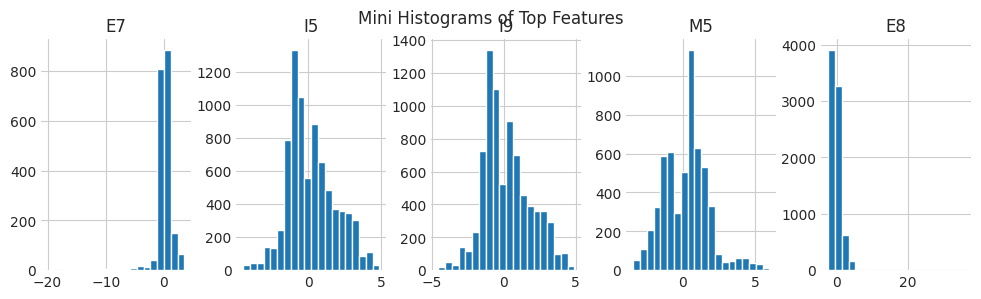

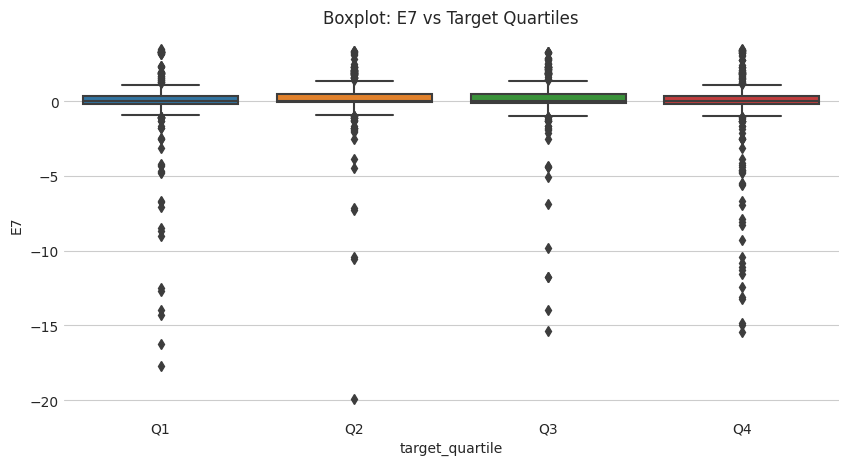

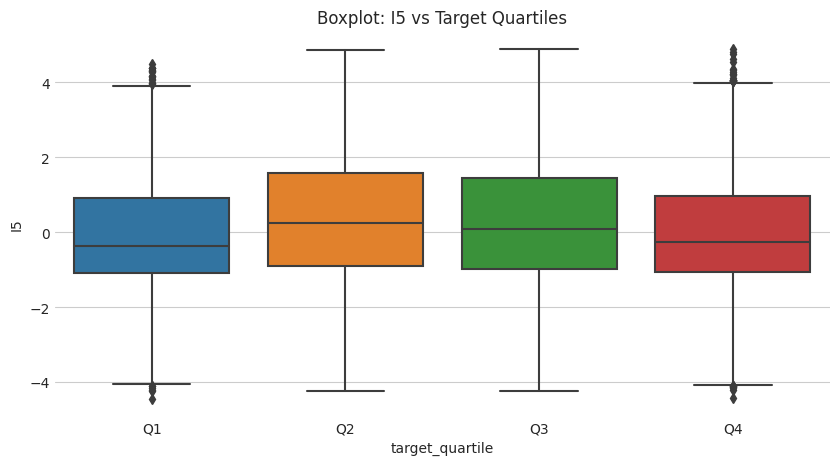

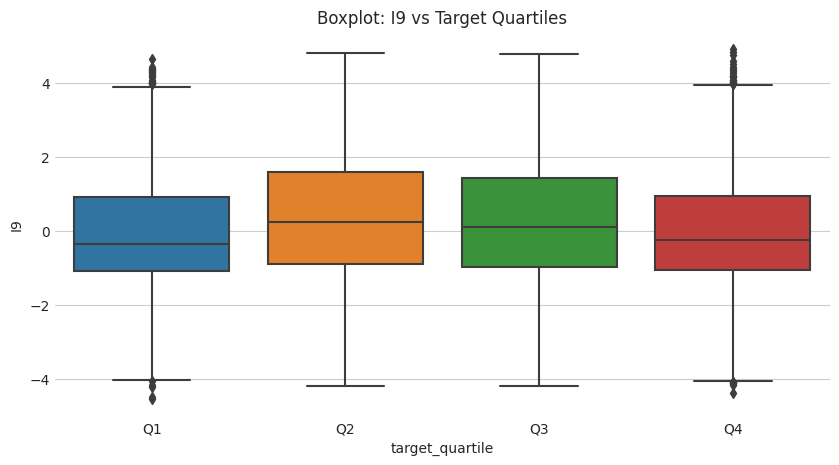

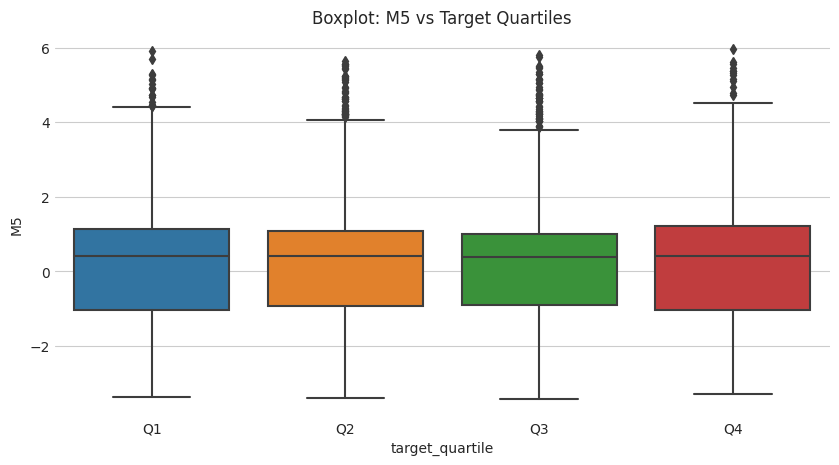

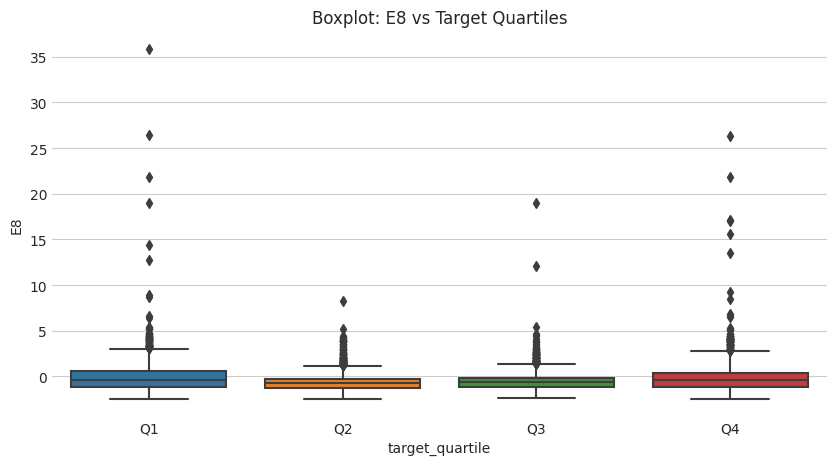

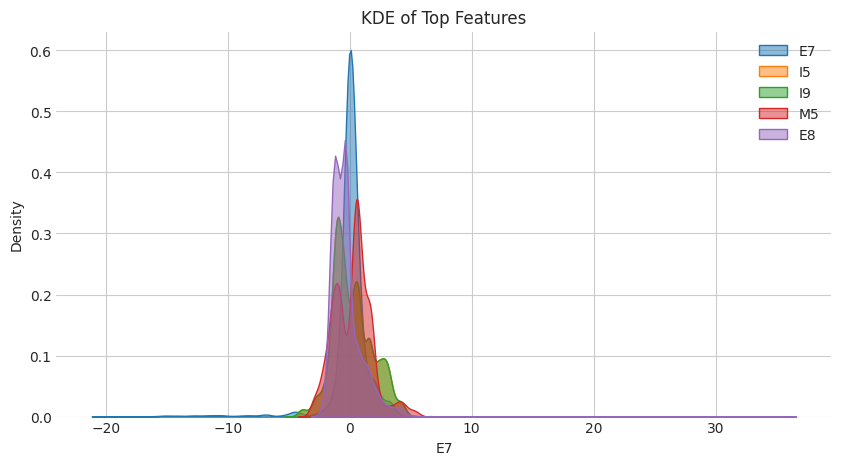

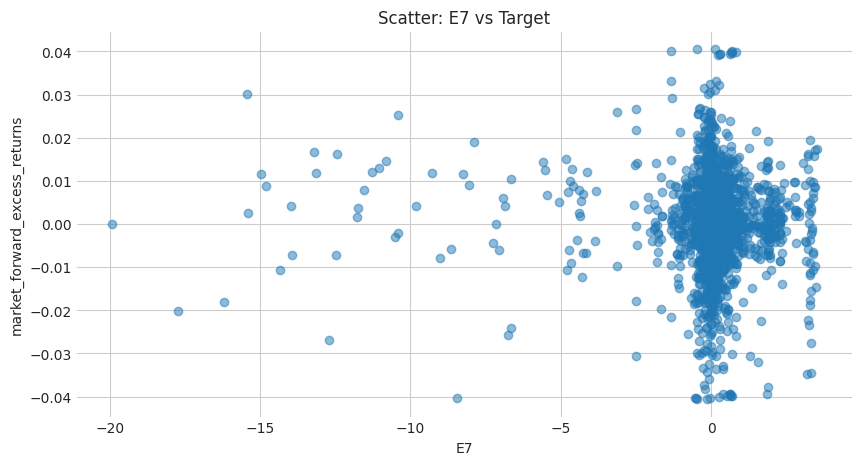

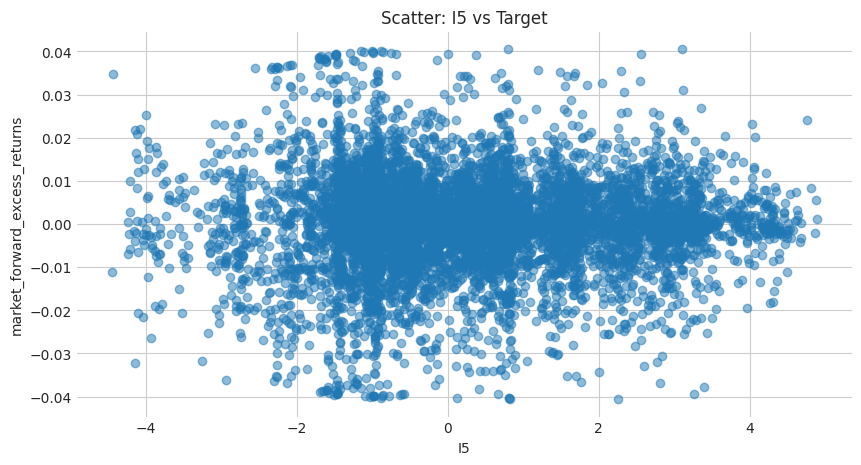

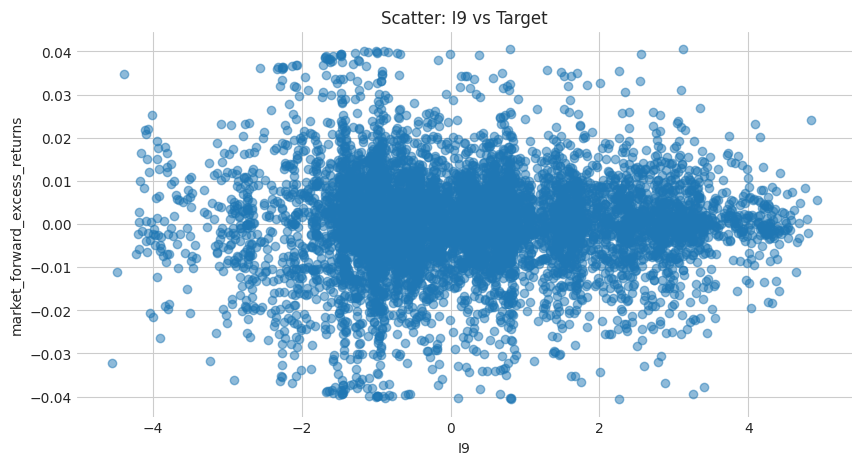

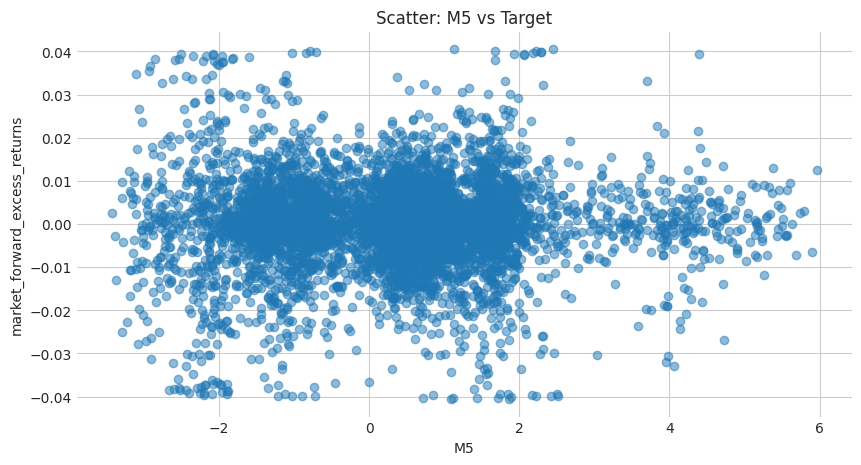

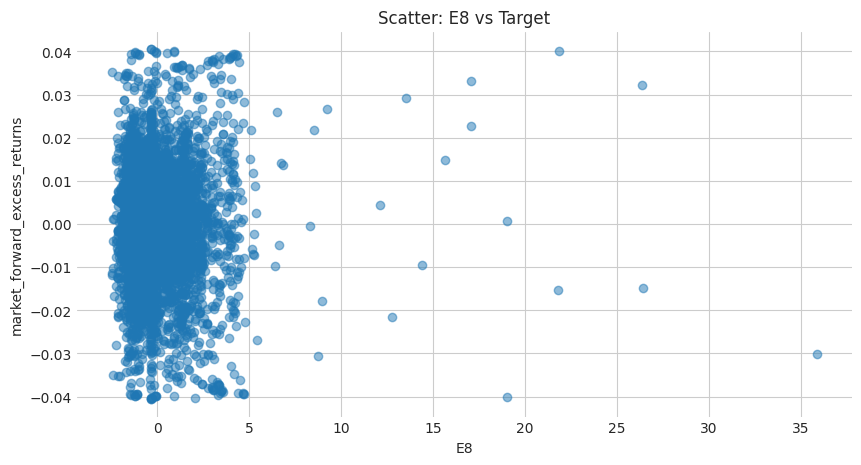

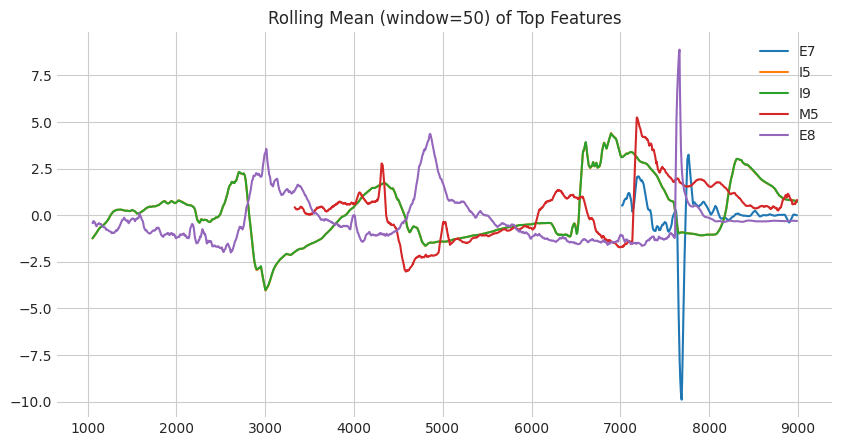

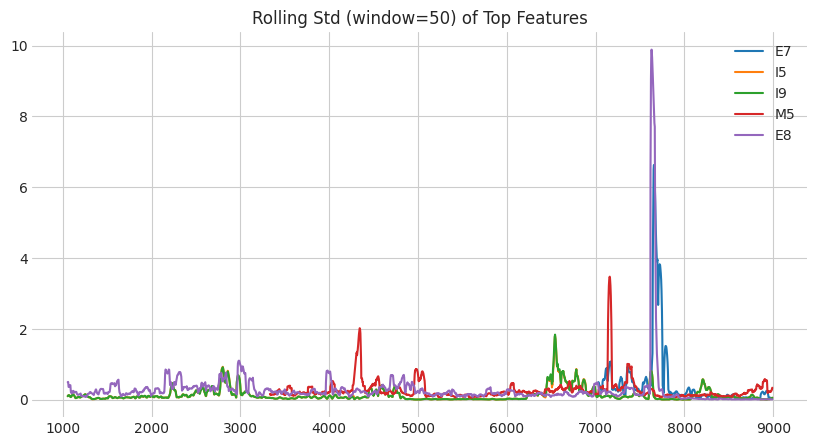

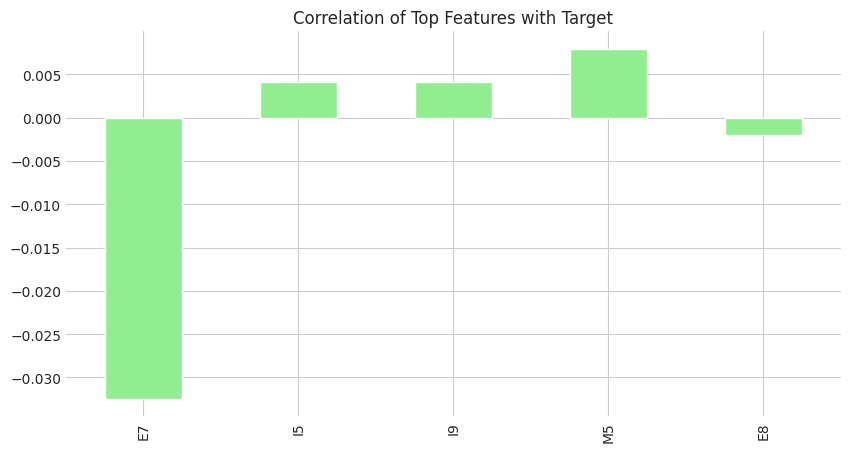

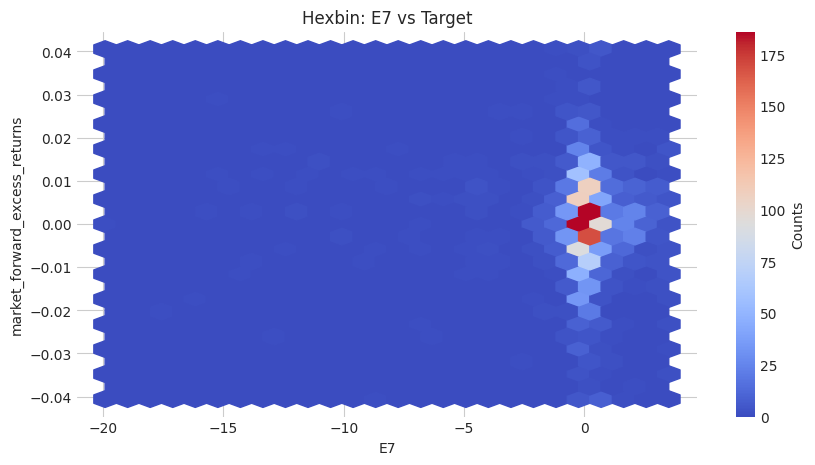

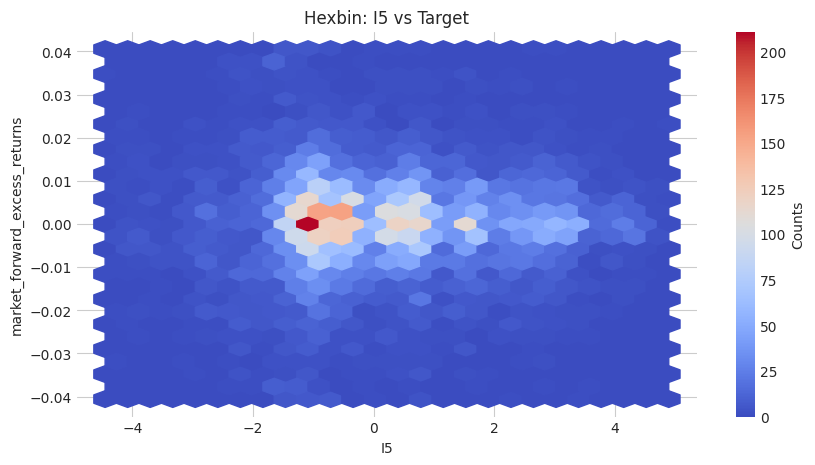

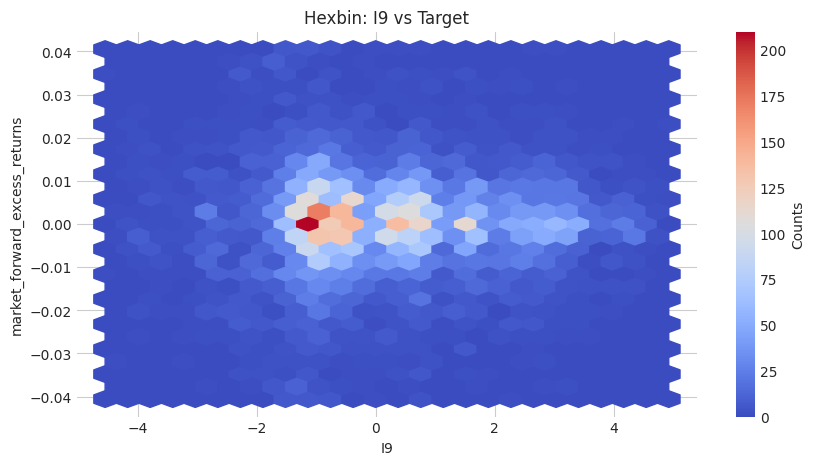

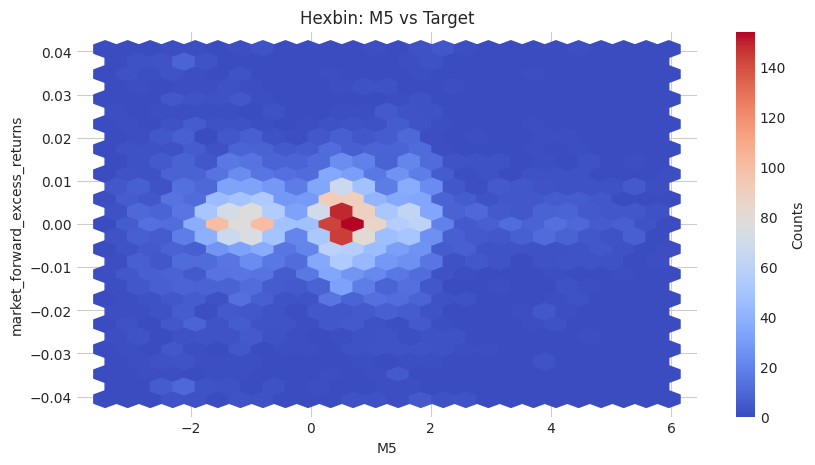

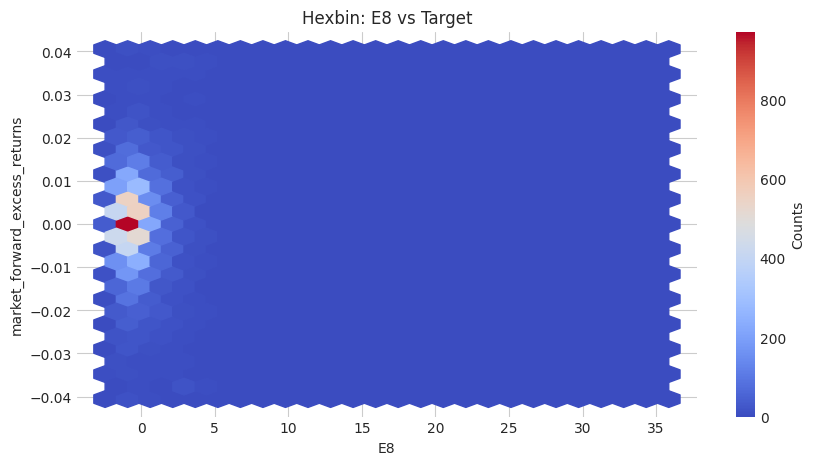

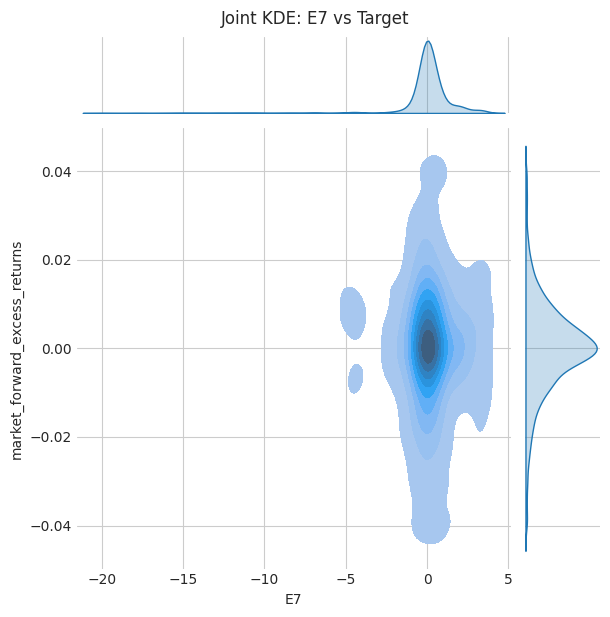

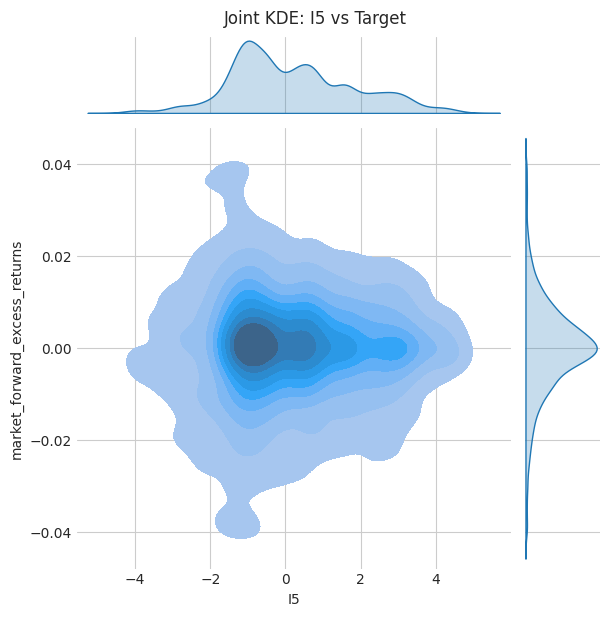

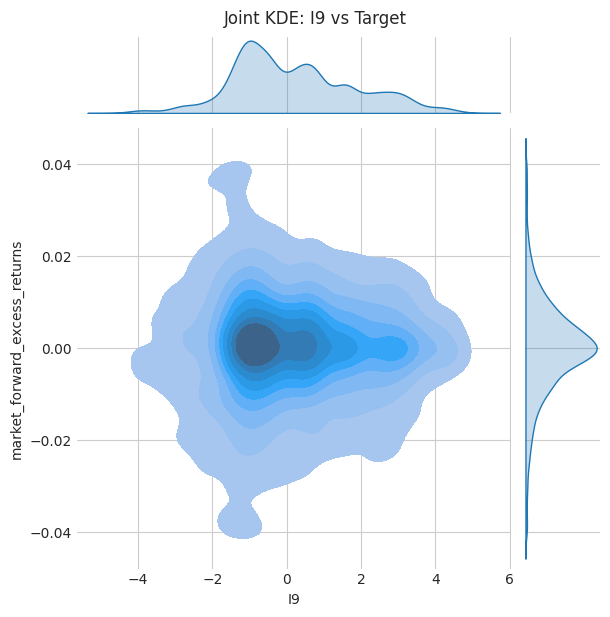

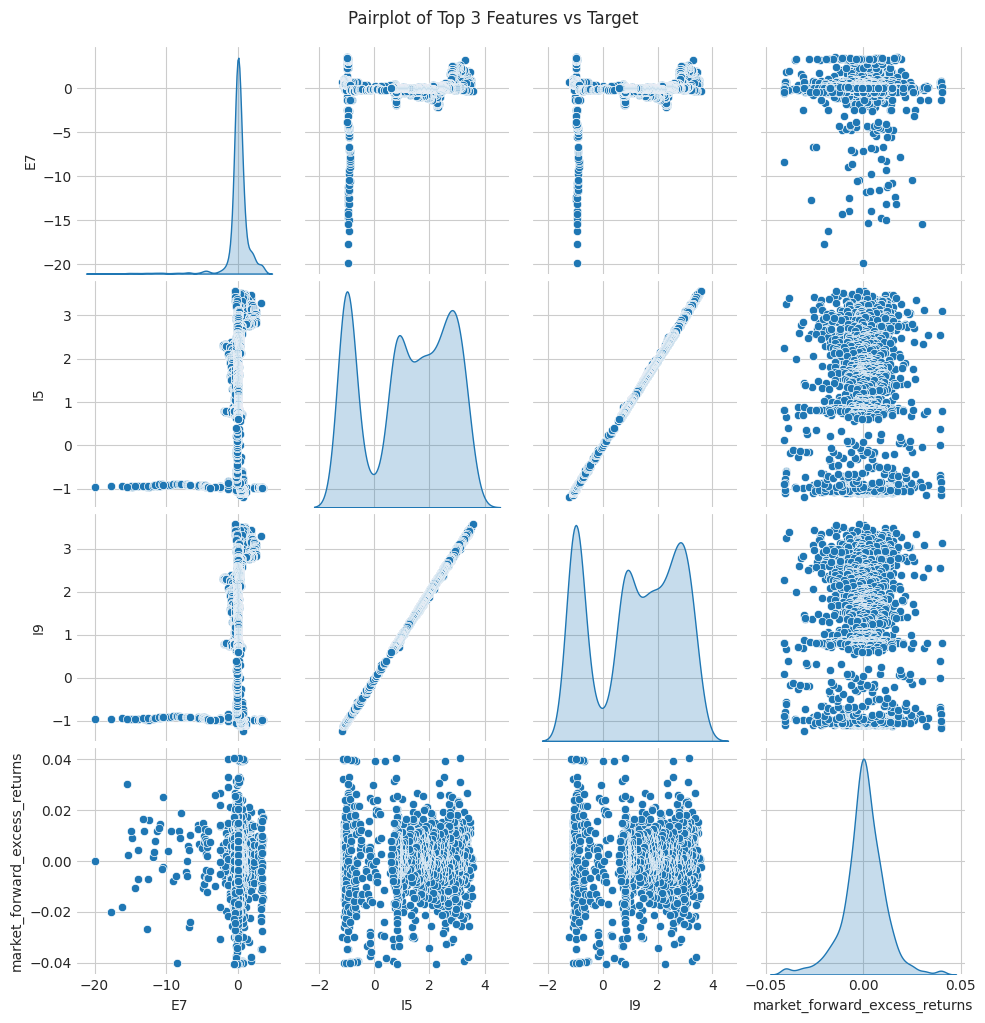

 10 Mini EDA Plots Completed!


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

plt.rcParams["figure.figsize"] = (10, 5)
sns.set_style("whitegrid")

# Ensure numeric features excluding target and date
num_cols = train_sorted.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["date_id", TARGET]]
top_feats = train_sorted[num_cols].var().sort_values(ascending=False).head(5).index.tolist()


# =========================
# 1) Mini Histogram Grid
# =========================
train_sorted[top_feats].hist(bins=20, layout=(1, len(top_feats)), figsize=(12,3))
plt.suptitle("Mini Histograms of Top Features")
plt.show()


# =========================
# 2) Mini Boxplots by Target Quartile
# =========================
train_sorted["target_quartile"] = pd.qcut(train_sorted[TARGET], 4, labels=["Q1","Q2","Q3","Q4"])
for f in top_feats:
    sns.boxplot(x="target_quartile", y=f, data=train_sorted)
    plt.title(f"Boxplot: {f} vs Target Quartiles")
    plt.show()


# =========================
# 3) Mini KDE Plots
# =========================
for f in top_feats:
    sns.kdeplot(train_sorted[f], label=f, fill=True, alpha=0.5)
plt.title("KDE of Top Features")
plt.legend()
plt.show()


# =========================
# 4) Mini Scatter Plots
# =========================
for f in top_feats:
    plt.scatter(train_sorted[f], train_sorted[TARGET], alpha=0.5)
    plt.xlabel(f); plt.ylabel(TARGET)
    plt.title(f"Scatter: {f} vs Target")
    plt.show()


# =========================
# 5) Mini Rolling Mean of Features
# =========================
window = 50
for f in top_feats:
    plt.plot(train_sorted["date_id"], train_sorted[f].rolling(window).mean(), label=f)
plt.title(f"Rolling Mean (window={window}) of Top Features")
plt.legend()
plt.show()


# =========================
# 6) Mini Rolling Std of Features
# =========================
for f in top_feats:
    plt.plot(train_sorted["date_id"], train_sorted[f].rolling(window).std(), label=f)
plt.title(f"Rolling Std (window={window}) of Top Features")
plt.legend()
plt.show()


# =========================
# 7) Mini Correlation Bar Plot
# =========================
corrs = train_sorted[top_feats + [TARGET]].corr()[TARGET].drop(TARGET)
corrs.plot(kind="bar", color="lightgreen")
plt.title("Correlation of Top Features with Target")
plt.show()


# =========================
# 8) Mini Hexbin Plots
# =========================
for f in top_feats:
    plt.hexbin(train_sorted[f], train_sorted[TARGET], gridsize=25, cmap="coolwarm")
    plt.xlabel(f); plt.ylabel(TARGET)
    plt.title(f"Hexbin: {f} vs Target")
    plt.colorbar(label="Counts")
    plt.show()


# =========================
# 9) Mini Jointplots (KDE)
# =========================
for f in top_feats[:3]:
    sns.jointplot(x=f, y=TARGET, data=train_sorted, kind="kde", fill=True)
    plt.suptitle(f"Joint KDE: {f} vs Target", y=1.02)
    plt.show()


# =========================
# 10) Mini Pairplot (Top 3 Features)
# =========================
sns.pairplot(train_sorted[top_feats[:3] + [TARGET]].dropna(), diag_kind="kde")
plt.suptitle("Pairplot of Top 3 Features vs Target", y=1.02)
plt.show()

print(" 10 Mini EDA Plots Completed!")


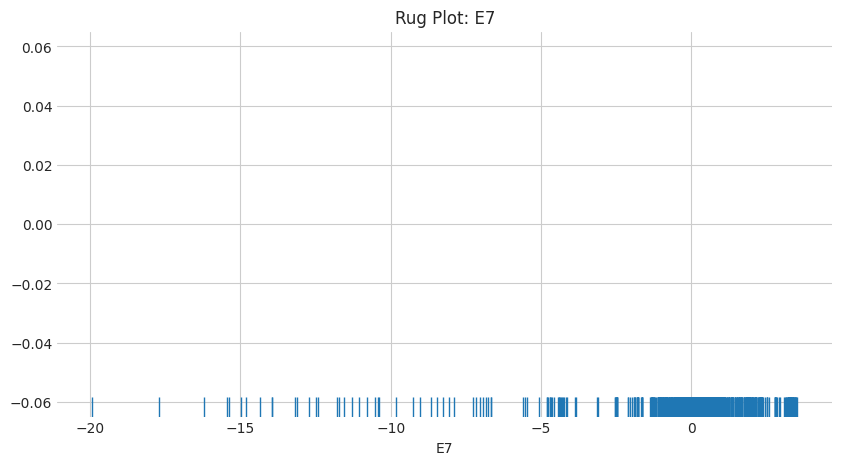

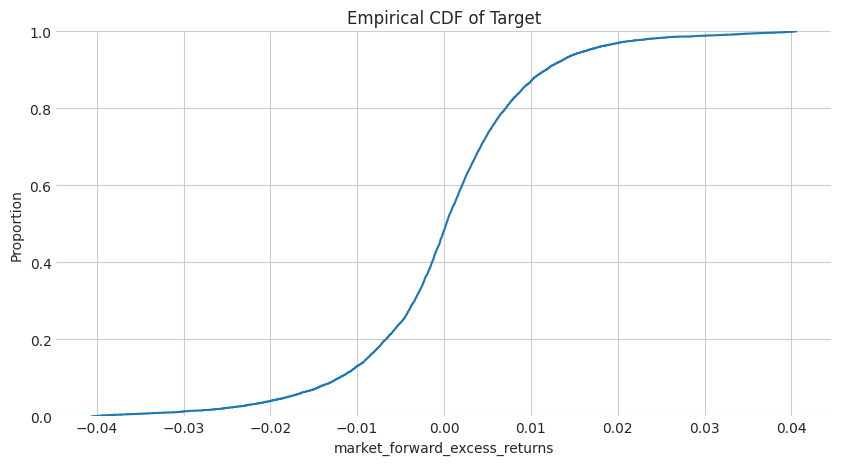

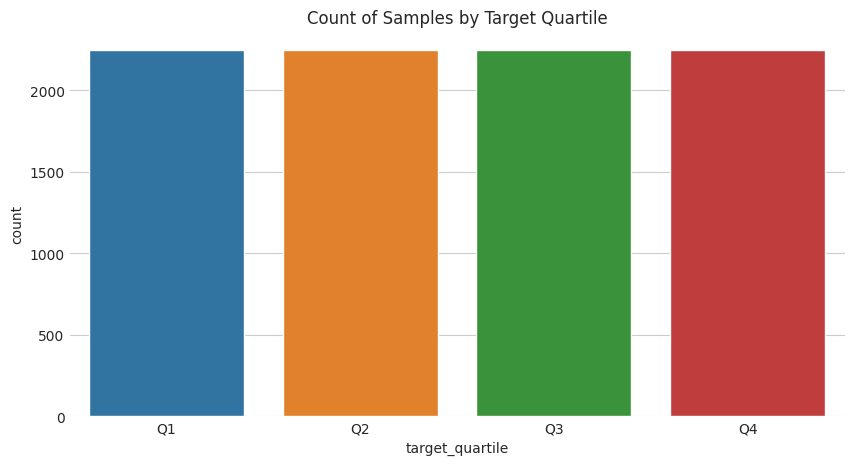

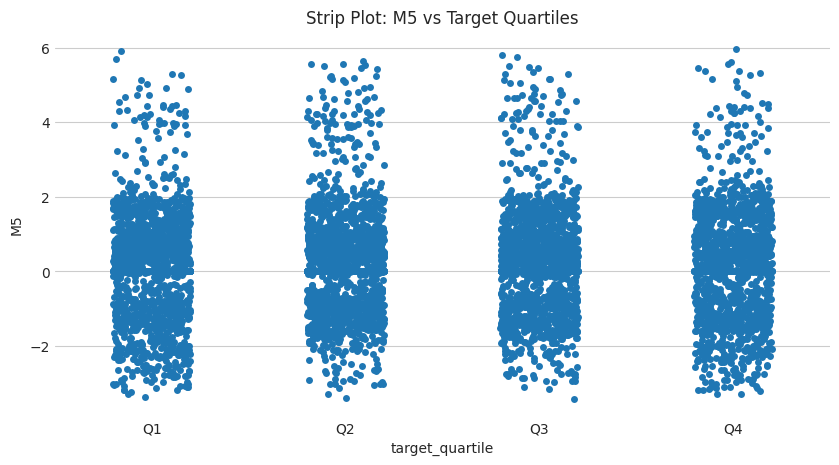

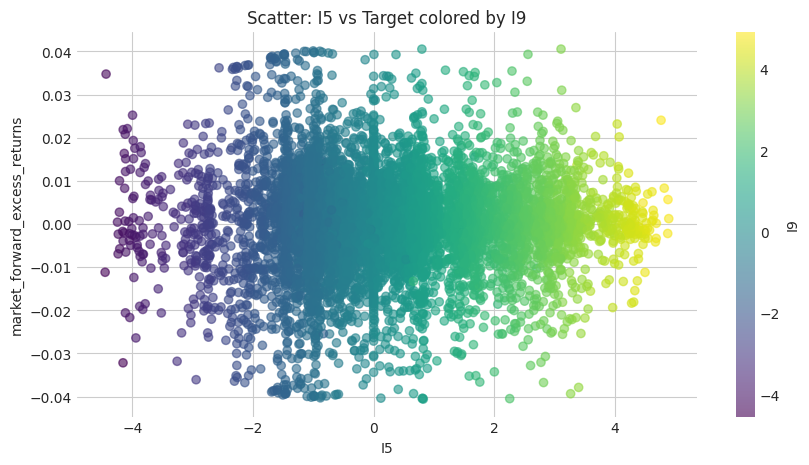

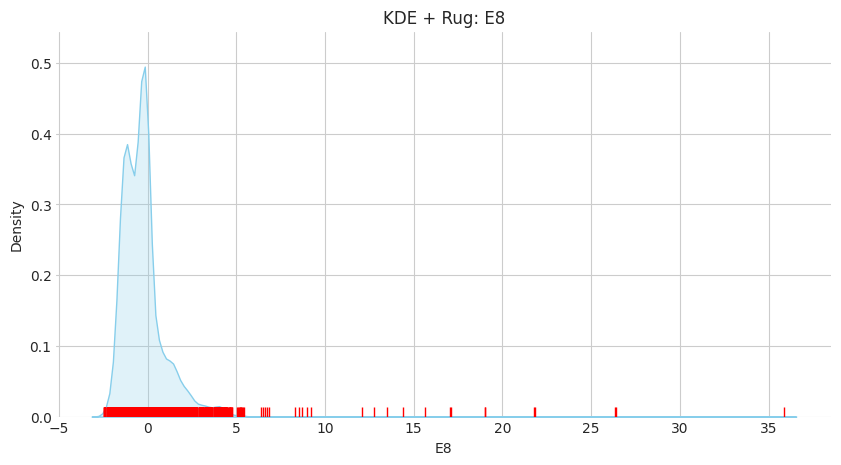

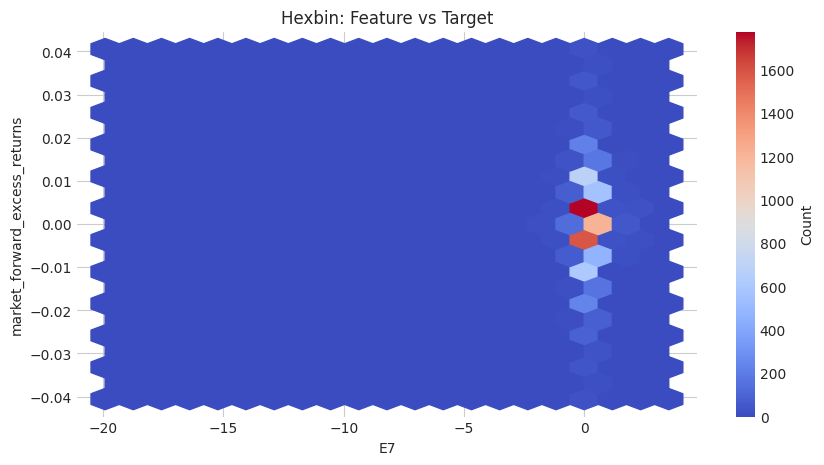

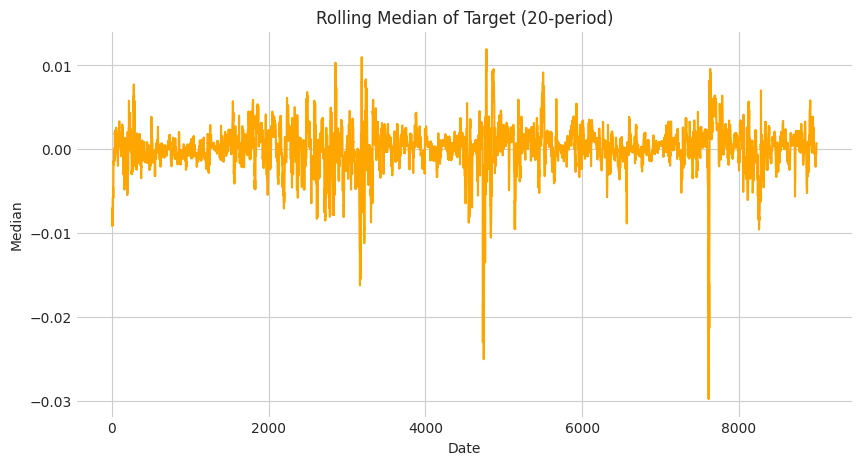

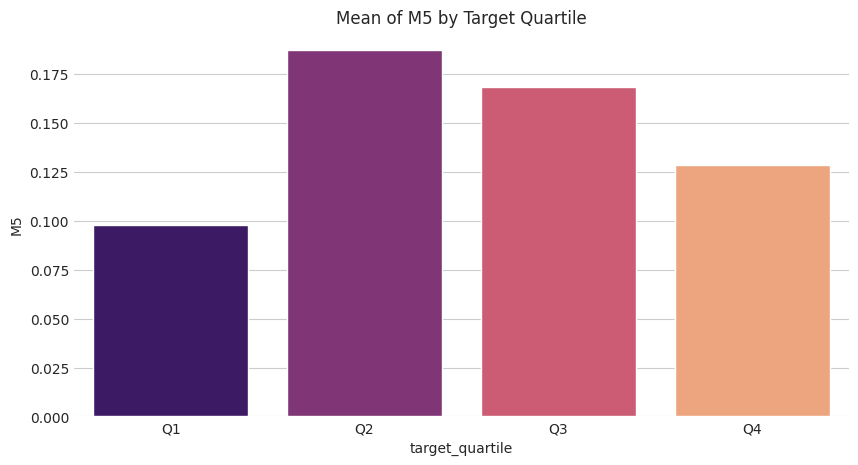

✅ 10 Mini EDA Plots Completed Successfully!


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

plt.rcParams["figure.figsize"] = (10, 5)
sns.set_style("whitegrid")

# ------------------------
# Prepare Numeric Features
# ------------------------
num_cols = train_sorted.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["date_id", TARGET]]
top_feats = train_sorted[num_cols].var().sort_values(ascending=False).head(5).index.tolist()

# ------------------------
# Create a filled copy for Plotly
# ------------------------
train_filled = train_sorted.copy()
train_filled[top_feats + [TARGET]] = train_filled[top_feats + [TARGET]].fillna(0)

# ===========================
# Rug Plot: Feature vs Target
# ===========================
sns.rugplot(x=train_sorted[top_feats[0]].fillna(0), height=0.05)
plt.title(f"Rug Plot: {top_feats[0]}")
plt.show()

# ===========================
# ECDF Plot
# ===========================
sns.ecdfplot(train_sorted[TARGET].fillna(0))
plt.title("Empirical CDF of Target")
plt.show()

# ===========================
# Countplot of Target Quartiles
# ===========================
train_sorted["target_quartile"] = pd.qcut(train_sorted[TARGET].fillna(0), 4, labels=["Q1","Q2","Q3","Q4"])
sns.countplot(x="target_quartile", data=train_sorted)
plt.title("Count of Samples by Target Quartile")
plt.show()

# ===========================
# Strip + Jitter Plot
# ===========================
train_sorted[top_feats[1]] = train_sorted[top_feats[1]].fillna(0)
sns.stripplot(
    x="target_quartile",
    y=top_feats[1],
    data=train_sorted,
    jitter=0.2
)
plt.title(f"Strip Plot: {top_feats[1]} vs Target Quartiles")
plt.show()

# ===========================
# Scatter with Color by Feature
# ===========================
plt.scatter(train_sorted[top_feats[2]].fillna(0), train_sorted[TARGET].fillna(0), 
            c=train_sorted[top_feats[3]].fillna(0), cmap="viridis", alpha=0.6)
plt.colorbar(label=top_feats[3])
plt.xlabel(top_feats[2]); plt.ylabel(TARGET)
plt.title(f"Scatter: {top_feats[2]} vs Target colored by {top_feats[3]}")
plt.show()

# ===========================
# KDE + Rug Overlay
# ===========================
sns.kdeplot(train_sorted[top_feats[4]].fillna(0), fill=True, color="skyblue")
sns.rugplot(train_sorted[top_feats[4]].fillna(0), color="red")
plt.title(f"KDE + Rug: {top_feats[4]}")
plt.show()

# ===========================
# Small Hexbin Plot
# ===========================
plt.hexbin(train_sorted[top_feats[0]].fillna(0), train_sorted[TARGET].fillna(0), gridsize=20, cmap="coolwarm")
plt.colorbar(label="Count")
plt.xlabel(top_feats[0]); plt.ylabel(TARGET)
plt.title("Hexbin: Feature vs Target")
plt.show()

# ===========================
# Rolling Median Plot
# ===========================
rolling_median = train_sorted[TARGET].rolling(20, min_periods=5).median()
plt.plot(train_sorted["date_id"], rolling_median, color="orange")
plt.title("Rolling Median of Target (20-period)")
plt.xlabel("Date"); plt.ylabel("Median")
plt.show()

# ===========================
# Bar Plot of Feature Means by Target Quartile
# ===========================
feat_means = train_sorted.groupby("target_quartile")[top_feats[1]].mean().reset_index()
sns.barplot(x="target_quartile", y=top_feats[1], data=feat_means, palette="magma")
plt.title(f"Mean of {top_feats[1]} by Target Quartile")
plt.show()

# ===========================
# Interactive Scatter Plot (Plotly)
# ===========================
#  Ensure size values are non-negative
size_col = top_feats[3]
train_filled[size_col] = train_filled[size_col].clip(lower=0)

fig = px.scatter(
    train_filled,
    x=top_feats[0],
    y=TARGET,
    color=top_feats[2],
    size=size_col,
    title=f"Interactive Scatter: {top_feats[0]} vs Target"
)
fig.show()

print("10 Mini EDA Plots Completed Successfully!")


2025-09-20 15:30:55.211747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758382255.502272      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758382255.578486      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using target column: market_forward_excess_returns
Using 94 common features for modeling.


2025-09-20 15:31:13.238381: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,537 (256.00 KB)

 Trainable params: 65,537 (256.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0713 - mae: 0.1717 - val_loss: 6.9737e-04 - val_mae: 0.0199
Epoch 2/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0027 - mae: 0.0384 - val_loss: 2.7479e-04 - val_mae: 0.0124
Epoch 3/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 1.8320e-04 - val_mae: 0.0102
Epoch 4/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5544e-04 - mae: 0.0186 - val_loss: 1.4851e-04 - val_mae: 0.0089
Epoch 5/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2889e-04 - mae: 0.0147 - val_loss: 1.3008e-04 - val_mae: 0.0083
Epoch 6/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7411e-04 - mae: 0.0119 - val_loss: 1.4110e-04 - val_mae: 0.0089
Epoch 7/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5342e-04 - mae: 0.0113 - val_loss: 1.4766e-04 - val_mae: 0.0092
Epoch 8/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9999e-04 - mae: 0.0105 - val_loss: 1.2802e-04 - val_mae: 0.0

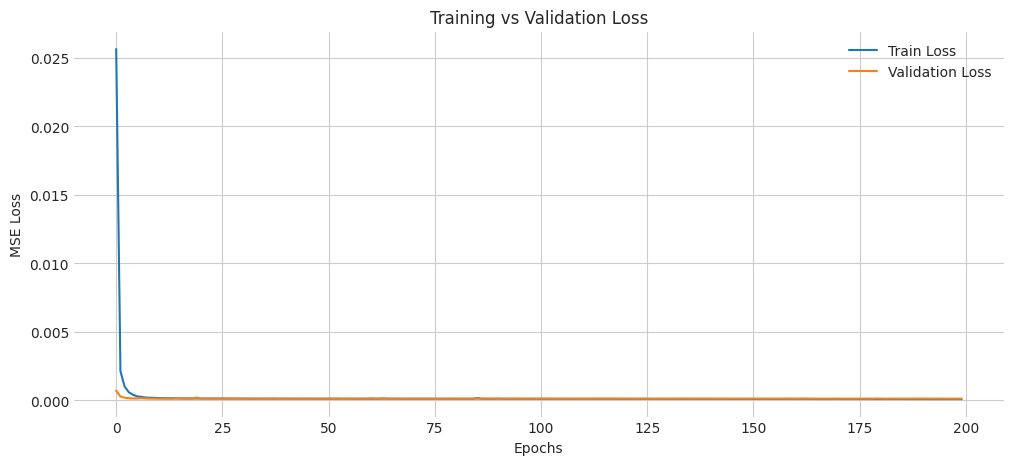

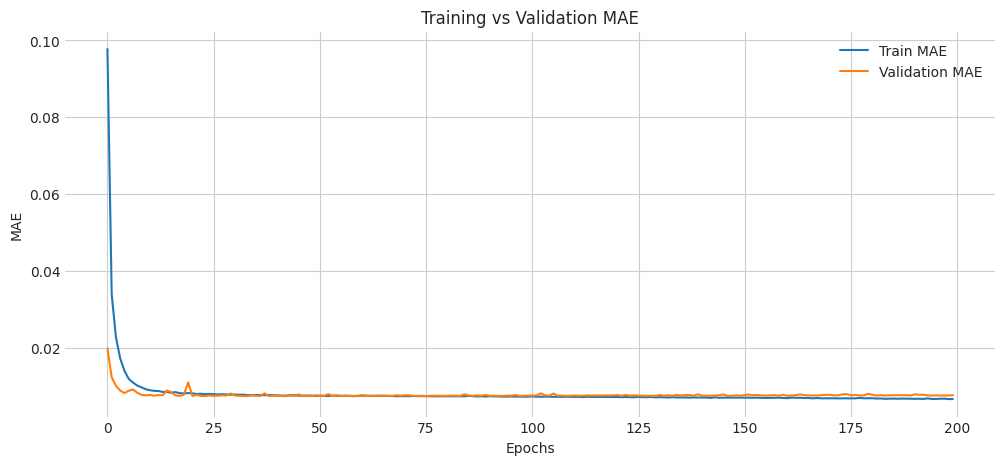

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
 Model training, evaluation, and submission complete!


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf

# ---------------------------
# 1) Load Data
# ---------------------------
train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
test = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')

# Automatically detect target column
if 'market_forward_excess_returns' in train.columns:
    TARGET = 'market_forward_excess_returns'
elif 'forward_returns' in train.columns:
    TARGET = 'forward_returns'
else:
    raise ValueError("No known target column found in train dataset.")

print(f"Using target column: {TARGET}")

# ---------------------------
# 2) Preprocessing
# ---------------------------
# Fill missing values
train.fillna(method='ffill', inplace=True)
train.fillna(method='bfill', inplace=True)
test.fillna(method='ffill', inplace=True)
test.fillna(method='bfill', inplace=True)

# Feature selection (exclude target and date)
train_features = [c for c in train.columns if c not in ['date_id', TARGET]]
# Only keep features common in both train and test
features = [f for f in train_features if f in test.columns]

print(f"Using {len(features)} common features for modeling.")

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train[features])
X_test = scaler.transform(test[features])
y_train = train[TARGET].values
y_test = test[TARGET].values if TARGET in test.columns else None

# Optional: split train into train/validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# ---------------------------
# 3) Build Custom Deep Learning Model
# ---------------------------
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

model.summary()

# ---------------------------
# 4) Train the Model
# ---------------------------
history = model.fit(
    X_train_sub, y_train_sub,
    validation_data=(X_val, y_val),
    epochs=200,        # increase for higher accuracy
    batch_size=32,
    verbose=1
)

# ---------------------------
# 5) Evaluate Model
# ---------------------------
if y_test is not None:
    y_pred_test = model.predict(X_test)
    print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
    print("Test MSE:", mean_squared_error(y_test, y_pred_test))
    print("Test R2 Score:", r2_score(y_test, y_pred_test))

# ---------------------------
# 6) Training History Plot
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.show()

# ---------------------------
# 7) Predictions & Submission
# ---------------------------
test_predictions = model.predict(X_test)
submission = pd.DataFrame({
    'date_id': test['date_id'],
    'predicted': test_predictions.flatten()
})
submission.to_csv('submission.csv', index=False)

print(" Model training, evaluation, and submission complete!")


Using target: market_forward_excess_returns
Using 94 features.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,537 (256.00 KB)

 Trainable params: 65,537 (256.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0372 - mae: 0.1235 - val_loss: 4.3721e-04 - val_mae: 0.0159
Epoch 2/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mae: 0.0282 - val_loss: 2.0015e-04 - val_mae: 0.0106
Epoch 3/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0354e-04 - mae: 0.0176 - val_loss: 1.3571e-04 - val_mae: 0.0086
Epoch 4/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7225e-04 - mae: 0.0139 - val_loss: 1.2819e-04 - val_mae: 0.0083
Epoch 5/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7903e-04 - mae: 0.0117 - val_loss: 1.1949e-04 - val_mae: 0.0079
Epoch 6/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0649e-04 - mae: 0.0104 - val_loss: 1.1979e-04 - val_mae: 0.0079
Epoch 7/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9073e-04 - mae: 0.0098 - val_loss: 1.1626e-04 - val_mae: 0.0078
Epoch 8/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7016e-04 - mae: 0.0092 - val_loss: 1.1609e-04 - val_mae:

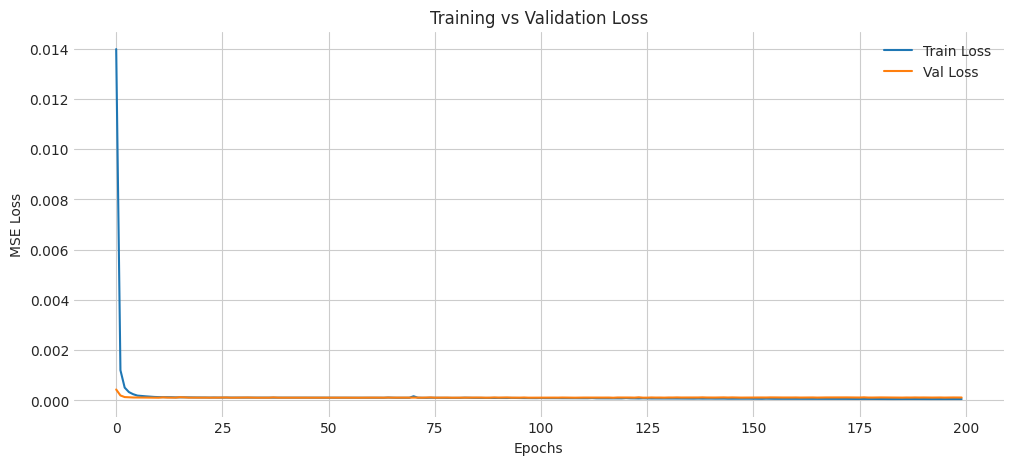

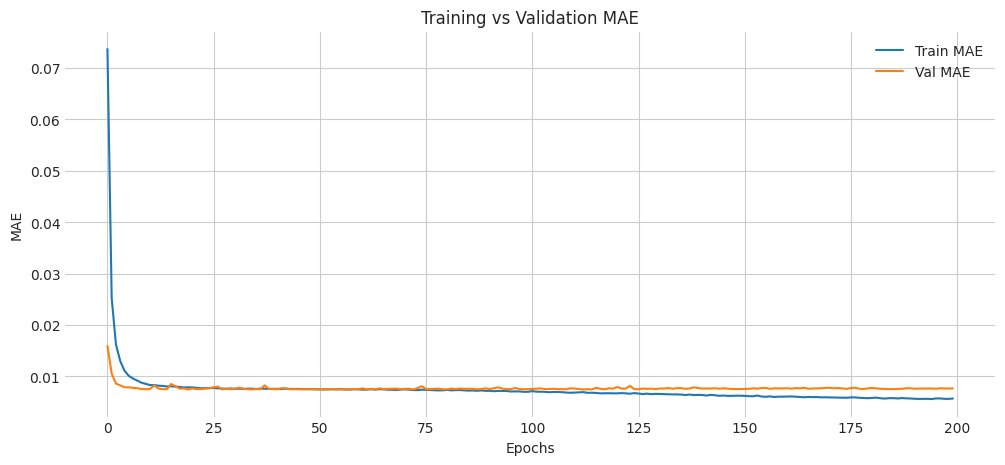

 Model saved at hull_market_model1.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
 Submission CSV saved!


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
)
import tensorflow as tf
import os

# ---------------------------
# 1) Load Data
# ---------------------------
train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
test = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')

# Detect target
if 'market_forward_excess_returns' in train.columns:
    TARGET = 'market_forward_excess_returns'
elif 'forward_returns' in train.columns:
    TARGET = 'forward_returns'
else:
    raise ValueError("No known target column found.")

print(f"Using target: {TARGET}")

# ---------------------------
# 2) Preprocessing
# ---------------------------
train.fillna(method='ffill', inplace=True)
train.fillna(method='bfill', inplace=True)
test.fillna(method='ffill', inplace=True)
test.fillna(method='bfill', inplace=True)

features = [f for f in train.columns if f not in ['date_id', TARGET] and f in test.columns]
print(f"Using {len(features)} features.")

scaler = StandardScaler()
X_train = scaler.fit_transform(train[features])
X_test = scaler.transform(test[features])
y_train = train[TARGET].values
y_test = test[TARGET].values if TARGET in test.columns else None

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# ---------------------------
# 3) Build Neural Network
# ---------------------------
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

model.summary()

# ---------------------------
# 4) Train Model
# ---------------------------
history = model.fit(
    X_train_sub, y_train_sub,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=1
)

# ---------------------------
# 5) Evaluate Model (Regression Metrics)
# ---------------------------
if y_test is not None:
    y_pred_test = model.predict(X_test).flatten()
    
    print("=== Regression Metrics ===")
    print("MAE:", mean_absolute_error(y_test, y_pred_test))
    print("MSE:", mean_squared_error(y_test, y_pred_test))
    print("R2 Score:", r2_score(y_test, y_pred_test))

    # ---------------------------
    # Convert to binary for classification metrics
    # 1 if return > 0 else 0
    y_test_class = (y_test > 0).astype(int)
    y_pred_class = (y_pred_test > 0).astype(int)
    
    print("\n=== Classification Metrics (Positive/Negative) ===")
    print("Accuracy:", accuracy_score(y_test_class, y_pred_class))
    print("F1 Score:", f1_score(y_test_class, y_pred_class))
    print("Recall:", recall_score(y_test_class, y_pred_class))
    print("Precision:", precision_score(y_test_class, y_pred_class))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class))
    print("\nClassification Report:\n", classification_report(y_test_class, y_pred_class))

# ---------------------------
# 6) Training History Plots
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.show()

# ---------------------------
# 7) Save Model
model_save_path = "hull_market_model1.h5"
model.save(model_save_path)
print(f" Model saved at {model_save_path}")


# ---------------------------
# 8) Predictions & Submission
# ---------------------------
test_predictions = model.predict(X_test).flatten()
submission = pd.DataFrame({
    'date_id': test['date_id'],
    'predicted': test_predictions
})
submission.to_csv('submission.csv', index=False)
print(" Submission CSV saved!")


In [14]:
 import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, confusion_matrix, roc_curve
)
import pickle

# ---------------------------
# 1) Load Data
# ---------------------------
train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
test = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')

TARGET = 'market_forward_excess_returns' if 'market_forward_excess_returns' in train.columns else 'forward_returns'

# ---------------------------
# 2) Feature Selection
# ---------------------------
features = [col for col in train.columns if col not in ['date_id', TARGET]]

X = train[features].fillna(0)
y = train[TARGET].fillna(0)

# Save feature list for later testing
with open('/kaggle/working/feature_list.pkl', 'wb') as f:
    pickle.dump(features, f)

# ---------------------------
# 3) Train/Test Split
# ---------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 4) Scaling
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ---------------------------
# 5) Build Model
# ---------------------------
def build_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # regression output
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )
    return model

model = build_model(X_train_scaled.shape[1])
model.summary()

# ---------------------------
# 6) Training
# ---------------------------
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30,
    batch_size=64,
    verbose=1
)

# ---------------------------
# 7) Save Model
# ---------------------------
model.save('/kaggle/working/hull_market_model.keras')
print(" Model saved!")

# ---------------------------
# 8) Evaluate on Test Dataset
# ---------------------------
# Reload model
model = tf.keras.models.load_model('/kaggle/working/hull_market_model.keras')

# Align features
with open('/kaggle/working/feature_list.pkl', 'rb') as f:
    features = pickle.load(f)

for f in features:
    if f not in test.columns:
        test[f] = 0

X_test = test[features].fillna(0)
X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled).flatten()
y_test = test[TARGET].values if TARGET in test.columns else None

# ---------------------------
# 9) Metrics
# ---------------------------
if y_test is not None:
    print("\n=== Regression Metrics ===")
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))

    y_test_class = (y_test > 0).astype(int)
    y_pred_class = (y_pred > 0).astype(int)

    print("\n=== Classification Metrics ===")
    print("Accuracy:", accuracy_score(y_test_class, y_pred_class))
    print("Precision:", precision_score(y_test_class, y_pred_class))
    print("Recall:", recall_score(y_test_class, y_pred_class))
    print("F1 Score:", f1_score(y_test_class, y_pred_class))
    print("ROC AUC:", roc_auc_score(y_test_class, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test_class, y_pred_class)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test_class, y_pred)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_class, y_pred):.4f}", linewidth=2)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

print("End-to-end training + testing pipeline completed!")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,049 (258.00 KB)

 Trainable params: 66,049 (258.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0854 - mae: 0.1986 - val_loss: 0.0020 - val_mae: 0.0347
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0057 - mae: 0.0577 - val_loss: 8.4267e-04 - val_mae: 0.0211
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026 - mae: 0.0380 - val_loss: 4.0151e-04 - val_mae: 0.0150
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - mae: 0.0295 - val_loss: 2.4362e-04 - val_mae: 0.0117
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3903e-04 - mae: 0.0226 - val_loss: 1.8919e-04 - val_mae: 0.0105
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.8076e-04 - mae: 0.0193 - val_loss: 1.7230e-04 - val_mae: 0.0098
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3242e-04 - mae: 0.0152 - val_loss: 1.0505e-04 - val_mae: 0.0077
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3661e-04 - mae: 0.0129 - val_loss: 8.9662e-05 - val_mae: 0.0070
Epoch 9/30
1